In [1]:
import ast
from pathlib import Path

import folium
import humanize
import pandas
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# U for Uber, T for T4c, O for OpenStreetMap
UBASEPATH = Path("/iarai/public/t4c/uber")
TBASEPATH = Path("/iarai/public/t4c/data_pipeline/release20221028_historic_uber")
OBASEPATH = Path("/iarai/public/t4c/osm")

CITY = "berlin"
YEAR = 2019
MONTH = 2
START_DAY = 1
END_DAY = 7  # incl.

# 2019-02-01 Fri
# 2019-02-02 Sat
# 2019-02-03 Sun
# 2019-02-04 Mon
# 2019-02-05 Tue
# 2019-02-06 Wed
# 2019-02-07 Thu

DAYTIME_START_HOUR = 8
DAYTIME_END_HOUR = 18
DAYTIME_HOURS = DAYTIME_END_HOUR - DAYTIME_START_HOUR

In [2]:
highway_ordering = [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
    "unclassified",
    "residential",
    "living_street",
    "service",
    "cycleway",
    "road",
    "construction",
]

In [3]:
plt.rcParams["axes.labelsize"] = 32
plt.rcParams['legend.title_fontsize'] = 28
plt.rcParams['legend.fontsize'] = 24

In [4]:
# simplified_filter = lambda hw: hw not in ['residential', 'living_street', 'service', 'road']
simplified_filter = lambda hw: hw in [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
]

In [5]:
def osm_color_palette():
    for c in ["#e892a2", "#e892a2", "#f9b29c", "#f9b29c", "#fcd6a4", "#fcd6a4", "#f7fabf", "#f7fabf"] + ["white"] * 99:
        yield c

## Load Uber segment speeds daytime and within bounding box

In [6]:
uspeeds_df = pandas.read_parquet(UBASEPATH / f"movement-speeds-hourly-{CITY}-{YEAR}-{MONTH}.parquet")
uspeeds_df = uspeeds_df[(uspeeds_df["day"] >= START_DAY) & (uspeeds_df["day"] <= END_DAY)]
# uspeeds_df['speed_kph_mean'] = uspeeds_df['speed_mph_mean'] * 1.60934
uspeeds_df = uspeeds_df.rename(columns={"osm_start_node_id": "u", "osm_end_node_id": "v", "osm_way_id": "osmid"})
uspeeds_df["gkey"] = [f"{u}_{v}_{osmid}" for u, v, osmid in zip(uspeeds_df["u"], uspeeds_df["v"], uspeeds_df["osmid"])]
uspeeds_df

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,u,v,speed_kph_mean,speed_kph_stddev,gkey
9,2019,2,3,0,2019-02-02T23:00:00.000Z,1f4bccb7a80046e3cd483789f351efe99e612d1a,f61823a7db684f4f2c94e9ff25da7e6710d95c76,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,169753571,1813307792,235637281,43.307,12.671,1813307792_235637281_169753571
15,2019,2,4,8,2019-02-04T07:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,49.318,6.877,29826350_4998526579_30253522
16,2019,2,2,3,2019-02-02T02:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,50.945,5.218,29826350_4998526579_30253522
17,2019,2,7,19,2019-02-07T18:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,43.392,4.337,29826350_4998526579_30253522
22,2019,2,6,21,2019-02-06T20:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,48.379,1.931,29826350_4998526579_30253522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668424,2019,2,6,19,2019-02-06T18:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,41.914,7.775,1277848884_27306422_4446505
1668432,2019,2,4,0,2019-02-03T23:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,45.300,5.087,1277848884_27306422_4446505
1668435,2019,2,7,10,2019-02-07T09:00:00.000Z,096727bb10e8a3a8e2ddec40f6cef865d70fd09a,e8de6f3ca9b2ee93d65d2032f8fb273b8460b539,4abbcb68cb49784af136e89c0d6fbcf14796820b,4623430,29365140,29365090,33.913,4.781,29365140_29365090_4623430
1668436,2019,2,7,9,2019-02-07T08:00:00.000Z,096727bb10e8a3a8e2ddec40f6cef865d70fd09a,e8de6f3ca9b2ee93d65d2032f8fb273b8460b539,4abbcb68cb49784af136e89c0d6fbcf14796820b,4623430,29365140,29365090,34.595,4.885,29365140_29365090_4623430


## Load our segment speeds and aggregate by hour

In [7]:
tspeeds_l = []
for i in range(START_DAY, END_DAY + 1):
    f = TBASEPATH / "speed_classes" / CITY / f"speed_classes_{YEAR}-{MONTH:02d}-{i:02d}.parquet"
    print(f)
    df = pd.read_parquet(f)
    # ['u', 'v', 'gkey', 'osmid', 'day', 't', 'volume_class', 'volume','median_speed_kph', 'mean_speed_kph', 'std_speed_kph', 'free_flow_kph'],
    #     print(df.columns)
    df["date"] = df["day"]
    df["year"] = YEAR
    df["month"] = MONTH
    df["day"] = i
    df["hour"] = df["t"] // 4
    df = (
        df[["u", "v", "gkey", "year", "month", "day", "hour", "volume", "volume_class", "median_speed_kph", "free_flow_kph", "std_speed_kph"]]
        .groupby(by=["u", "v", "gkey", "year", "month", "day", "hour"])
        .agg(
            volume_class=("volume_class", "mean"),
            volume=("volume", "mean"),
            std_speed_kph=("std_speed_kph", "mean"),
            median_speed_kph=("median_speed_kph", "mean"),
            free_flow_kph=("free_flow_kph", "first"),
        )
        .reset_index()
    )
    tspeeds_l.append(df)
tspeeds_df = pandas.concat(tspeeds_l)
# tspeeds_df = tspeeds_df.rename(columns={'osmid': 'osm_way_id'})
tspeeds_df

/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-01.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-02.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-03.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-04.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-05.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-06.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-07.parquet


,u,v,gkey,year,month,day,hour,volume_class,volume,std_speed_kph,median_speed_kph,free_flow_kph
0,172546,530313,172546_530313_24295532,2019,2,1,0,4.000000,7.500000,0.0,48.235294,48.156863
1,172546,530313,172546_530313_24295532,2019,2,1,1,4.000000,4.000000,0.0,48.235294,48.156863
2,172546,530313,172546_530313_24295532,2019,2,1,2,3.000000,3.000000,0.0,44.235294,48.156863
3,172546,530313,172546_530313_24295532,2019,2,1,4,3.000000,3.000000,0.0,44.705882,48.156863
4,172546,530313,172546_530313_24295532,2019,2,1,5,1.000000,2.000000,0.0,47.058824,48.156863
...,...,...,...,...,...,...,...,...,...,...,...,...
366360,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,19,5.000000,12.333333,0.0,37.098039,42.352941
366361,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,20,3.000000,3.666667,0.0,41.254902,42.352941
366362,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,21,1.666667,2.666667,0.0,41.568627,42.352941
366363,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,22,5.000000,8.500000,0.0,32.470588,42.352941


In [8]:
u_ids = set(zip(uspeeds_df["u"], uspeeds_df["v"], uspeeds_df["gkey"]))
u_ids

{(26627378, 26805916, '26627378_26805916_409524989'),
 (1992100022, 408194196, '1992100022_408194196_192158399'),
 (197335843, 2865693549, '197335843_2865693549_284757120'),
 (29218322, 29218323, '29218322_29218323_53599862'),
 (26876325, 727384649, '26876325_727384649_195259831'),
 (26746053, 161921875, '26746053_161921875_102486222'),
 (27786595, 27786223, '27786595_27786223_4531624'),
 (27587418, 26904731, '27587418_26904731_4604840'),
 (26704570, 3180634749, '26704570_3180634749_112427848'),
 (383210383, 29786488, '383210383_29786488_35552254'),
 (26868064, 26868065, '26868064_26868065_4616330'),
 (791370736, 4558800531, '791370736_4558800531_61961008'),
 (26731289, 26734491, '26731289_26734491_4413754'),
 (2055808362, 25661397, '2055808362_25661397_24913267'),
 (29273065, 297277431, '29273065_297277431_4741948'),
 (2796688606, 614674365, '2796688606_614674365_77348147'),
 (29207433, 29207423, '29207433_29207423_4611696'),
 (29273049, 1289066109, '29273049_1289066109_4616239'),
 (2

In [9]:
t_ids = set(zip(tspeeds_df["u"], tspeeds_df["v"], tspeeds_df["gkey"]))
t_ids

{(4567833452, 4567833453, '4567833452_4567833453_338316875'),
 (26627378, 26805916, '26627378_26805916_409524989'),
 (1992100022, 408194196, '1992100022_408194196_192158399'),
 (197335843, 2865693549, '197335843_2865693549_284757120'),
 (26746053, 161921875, '26746053_161921875_102486222'),
 (26876325, 727384649, '26876325_727384649_195259831'),
 (29218322, 29218323, '29218322_29218323_53599862'),
 (27786595, 27786223, '27786595_27786223_4531624'),
 (336583915, 26729648, '336583915_26729648_30497058'),
 (27587418, 26904731, '27587418_26904731_4604840'),
 (842553922, 28255081, '842553922_28255081_82456678'),
 (26704570, 3180634749, '26704570_3180634749_112427848'),
 (383210383, 29786488, '383210383_29786488_35552254'),
 (29655489, 2756762303, '29655489_2756762303_155586405'),
 (26868064, 26868065, '26868064_26868065_4616330'),
 (26731289, 26734491, '26731289_26734491_4413754'),
 (791370736, 4558800531, '791370736_4558800531_61961008'),
 (2055808362, 25661397, '2055808362_25661397_249132

In [10]:
# does not hold with the restricted time frame...
# assert t_ids.issubset(u_ids)

## Restrict to daytime only

In [11]:
tspeeds_df = tspeeds_df[(tspeeds_df["hour"] >= DAYTIME_START_HOUR) & (tspeeds_df["hour"] < DAYTIME_END_HOUR)]
tspeeds_df

,u,v,gkey,year,month,day,hour,volume_class,volume,std_speed_kph,median_speed_kph,free_flow_kph
7,172546,530313,172546_530313_24295532,2019,2,1,8,5.0,12.000000,0.0,42.849673,48.156863
8,172546,530313,172546_530313_24295532,2019,2,1,9,3.5,6.500000,0.0,43.764706,48.156863
9,172546,530313,172546_530313_24295532,2019,2,1,10,4.0,6.500000,0.0,44.529412,48.156863
10,172546,530313,172546_530313_24295532,2019,2,1,11,5.0,14.750000,0.0,39.529412,48.156863
11,172546,530313,172546_530313_24295532,2019,2,1,12,4.5,11.000000,0.0,39.137255,48.156863
...,...,...,...,...,...,...,...,...,...,...,...,...
366354,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,13,5.0,30.500000,0.0,21.352941,42.352941
366355,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,14,4.5,23.250000,0.0,27.921569,42.352941
366356,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,15,5.0,21.333333,0.0,20.549020,42.352941
366357,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,16,5.0,29.500000,0.0,27.156863,42.352941


In [12]:
uspeeds_df = uspeeds_df[(uspeeds_df["hour"] >= DAYTIME_START_HOUR) & (uspeeds_df["hour"] < DAYTIME_END_HOUR)]
uspeeds_df

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,u,v,speed_kph_mean,speed_kph_stddev,gkey
15,2019,2,4,8,2019-02-04T07:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,49.318,6.877,29826350_4998526579_30253522
60,2019,2,3,10,2019-02-03T09:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,52.530,4.866,29826350_4998526579_30253522
62,2019,2,6,8,2019-02-06T07:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,48.073,5.858,29826350_4998526579_30253522
80,2019,2,1,11,2019-02-01T10:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,39.441,8.694,29826350_4998526579_30253522
82,2019,2,4,17,2019-02-04T16:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,4998526579,42.078,2.724,29826350_4998526579_30253522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668414,2019,2,7,11,2019-02-07T10:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,44.201,5.211,1277848884_27306422_4446505
1668418,2019,2,4,9,2019-02-04T08:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,45.820,3.331,1277848884_27306422_4446505
1668419,2019,2,7,14,2019-02-07T13:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,44.547,3.398,1277848884_27306422_4446505
1668435,2019,2,7,10,2019-02-07T09:00:00.000Z,096727bb10e8a3a8e2ddec40f6cef865d70fd09a,e8de6f3ca9b2ee93d65d2032f8fb273b8460b539,4abbcb68cb49784af136e89c0d6fbcf14796820b,4623430,29365140,29365090,33.913,4.781,29365140_29365090_4623430


## Merge with road graph in bounding box

In [13]:
df_edges = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_edges.parquet")
df_edges

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name
0,172546_530313_24295532,172546,530313,24295532,50.0,50,secondary,,,,46.759468,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd8\xbc...,Emmentaler Straße
1,172558_172559_160130963,172558,172559,160130963,50.0,50,primary,,,,164.463017,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xbepB|\...,Müllerstraße
2,172559_29688040_160130963,172559,29688040,160130963,50.0,50,primary,,,,153.966487,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x0f\x14...,Müllerstraße
3,172562_530351_4804203,172562,530351,4804203,50.0,50,primary_link,,,,23.283372,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd3\xe8...,
4,172564_530185_4432669,172564,530185,4432669,50.0,50,secondary,,,,44.345716,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xc9I\x1...,Kurt-Schumacher-Platz
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16274,6171409045_6171409044_71143837,6171409045,6171409044,71143837,50.0,50,secondary,,,,71.576136,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x7f\xd9...,Axel-Springer-Straße
16275,6172685050_26745400_417807344,6172685050,26745400,417807344,50.0,50,residential,,,,5.821343,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xfbn\x0...,Bendlerbrücke
16276,6172693100_26746095_16943617,6172693100,26746095,16943617,30.0,30,primary,,,,9.151821,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00z\xbbo\x...,Potsdamer Straße
16277,6173378369_426425009_132105452,6173378369,426425009,132105452,50.0,50,tertiary,,,,3.764184,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd8R\xf...,Lückstraße


In [14]:
df_nodes = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_nodes.parquet")
df_nodes

,node_id,x,y,geometry
0,172546,13.352255,52.567738,b'\x01\x01\x00\x00\x00\xd8\xbc\xaa\xb3Z\xb4*@%...
1,172558,13.337368,52.558781,b'\x01\x01\x00\x00\x00\xbepB|\xbb\xac*@h\x11@ ...
2,172559,13.336074,52.559517,b'\x01\x01\x00\x00\x00\x0f\x14\xd3\xe0\x11\xac...
3,172562,13.330664,52.562600,b'\x01\x01\x00\x00\x00\xd3\xe8\xc4\xd4L\xa9*@\...
4,172564,13.327708,52.564046,b'\x01\x01\x00\x00\x00\xc9I\x17Q\xc9\xa7*@\x87...
...,...,...,...,...
12650,6171409045,13.399112,52.508193,b'\x01\x01\x00\x00\x00\x7f\xd9=yX\xcc*@qHYu\x0...
12651,6172685050,13.362564,52.505849,b'\x01\x01\x00\x00\x00\xfbn\x04\xf3\xa1\xb9*@\...
12652,6172693100,13.368124,52.505898,b'\x01\x01\x00\x00\x00z\xbbo\xc6z\xbc*@P\x8e\x...
12653,6173378369,13.491984,52.501171,b'\x01\x01\x00\x00\x00\xd8R\xf6L\xe5\xfb*@\xbd...


In [15]:
df_edges = df_edges.merge(df_nodes, left_on="u", right_on="node_id", suffixes=["", "_u"]).merge(df_nodes, left_on="v", right_on="node_id", suffixes=["", "_v"])
df_edges.rename(columns={"x": "x_u", "y": "y_u"}, inplace=True)
del df_edges["geometry_u"]
del df_edges["geometry_v"]
df_edges

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v
0,172546_530313_24295532,172546,530313,24295532,50.0,50,secondary,,,,46.759468,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd8\xbc...,Emmentaler Straße,172546,13.352255,52.567738,530313,13.352664,52.567835
1,172558_172559_160130963,172558,172559,160130963,50.0,50,primary,,,,164.463017,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xbepB|\...,Müllerstraße,172558,13.337368,52.558781,172559,13.336074,52.559517
2,172559_29688040_160130963,172559,29688040,160130963,50.0,50,primary,,,,153.966487,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x0f\x14...,Müllerstraße,172559,13.336074,52.559517,29688040,13.334868,52.560216
3,172562_530351_4804203,172562,530351,4804203,50.0,50,primary_link,,,,23.283372,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd3\xe8...,,172562,13.330664,52.562600,530351,13.330466,52.562532
4,2869415442_530351_283022996,2869415442,530351,283022996,50.0,50,secondary,,,,75.539975,"b""\x01\x02\x00\x00\x00\x06\x00\x00\x00\xb4\xaa...",Scharnweberstraße,2869415442,13.329873,52.562873,530351,13.330466,52.562532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16274,6171409041_6171409040_335462871,6171409041,6171409040,335462871,50.0,50,secondary,,,,81.025436,"b""\x01\x02\x00\x00\x00\x02\x00\x00\x00\xf4w\xa...",Axel-Springer-Straße,6171409041,13.398614,52.507512,6171409040,13.399054,52.508109
16275,6171409045_6171409040_335462871,6171409045,6171409040,335462871,50.0,50,secondary,,,,11.137605,"b""\x01\x02\x00\x00\x00\x02\x00\x00\x00\x7f\xd9...",Axel-Springer-Straße,6171409045,13.399112,52.508193,6171409040,13.399054,52.508109
16276,6171409044_6171409042_24214231,6171409044,6171409042,24214231,50.0,50,secondary,,,,52.700663,"b""\x01\x02\x00\x00\x00\x03\x00\x00\x00\xcb&e\x...",Axel-Springer-Straße,6171409044,13.399490,52.508729,6171409042,13.399812,52.509086
16277,6173378369_426425009_132105452,6173378369,426425009,132105452,50.0,50,tertiary,,,,3.764184,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd8R\xf...,Lückstraße,6173378369,13.491984,52.501171,426425009,13.492017,52.501164


In [16]:
def in_bb(x, y):
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

In [17]:
# Berlin
y_min, y_max, x_min, x_max = 52.35900, 52.85400, 13.18900, 13.62500

In [18]:
df_edges["in_bb"] = [(in_bb(x_u, y_u) or in_bb(x_v, y_v)) for x_u, y_u, x_v, y_v in zip(df_edges["x_u"], df_edges["y_u"], df_edges["x_v"], df_edges["y_v"])]

In [19]:
df_edges = df_edges[df_edges["in_bb"] == True]
df_edges

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb
0,172546_530313_24295532,172546,530313,24295532,50.0,50,secondary,,,,46.759468,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd8\xbc...,Emmentaler Straße,172546,13.352255,52.567738,530313,13.352664,52.567835,True
1,172558_172559_160130963,172558,172559,160130963,50.0,50,primary,,,,164.463017,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xbepB|\...,Müllerstraße,172558,13.337368,52.558781,172559,13.336074,52.559517,True
2,172559_29688040_160130963,172559,29688040,160130963,50.0,50,primary,,,,153.966487,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x0f\x14...,Müllerstraße,172559,13.336074,52.559517,29688040,13.334868,52.560216,True
3,172562_530351_4804203,172562,530351,4804203,50.0,50,primary_link,,,,23.283372,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd3\xe8...,,172562,13.330664,52.562600,530351,13.330466,52.562532,True
4,2869415442_530351_283022996,2869415442,530351,283022996,50.0,50,secondary,,,,75.539975,"b""\x01\x02\x00\x00\x00\x06\x00\x00\x00\xb4\xaa...",Scharnweberstraße,2869415442,13.329873,52.562873,530351,13.330466,52.562532,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16274,6171409041_6171409040_335462871,6171409041,6171409040,335462871,50.0,50,secondary,,,,81.025436,"b""\x01\x02\x00\x00\x00\x02\x00\x00\x00\xf4w\xa...",Axel-Springer-Straße,6171409041,13.398614,52.507512,6171409040,13.399054,52.508109,True
16275,6171409045_6171409040_335462871,6171409045,6171409040,335462871,50.0,50,secondary,,,,11.137605,"b""\x01\x02\x00\x00\x00\x02\x00\x00\x00\x7f\xd9...",Axel-Springer-Straße,6171409045,13.399112,52.508193,6171409040,13.399054,52.508109,True
16276,6171409044_6171409042_24214231,6171409044,6171409042,24214231,50.0,50,secondary,,,,52.700663,"b""\x01\x02\x00\x00\x00\x03\x00\x00\x00\xcb&e\x...",Axel-Springer-Straße,6171409044,13.399490,52.508729,6171409042,13.399812,52.509086,True
16277,6173378369_426425009_132105452,6173378369,426425009,132105452,50.0,50,tertiary,,,,3.764184,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd8R\xf...,Lückstraße,6173378369,13.491984,52.501171,426425009,13.492017,52.501164,True


In [20]:
ut_merged = uspeeds_df.merge(tspeeds_df, on=["u", "v", "gkey", "year", "month", "day", "hour"]).merge(df_edges, on=["u", "v", "gkey"])
ut_merged

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid_x,u,...,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb
0,2019,2,4,8,2019-02-04T07:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xe3U\xd...,Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True
1,2019,2,3,10,2019-02-03T09:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xe3U\xd...,Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True
2,2019,2,6,8,2019-02-06T07:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xe3U\xd...,Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True
3,2019,2,1,11,2019-02-01T10:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xe3U\xd...,Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True
4,2019,2,4,17,2019-02-04T16:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xe3U\xd...,Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166035,2019,2,7,11,2019-02-07T10:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,...,78.011138,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x03\xed...,Sophie-Charlotte-Platz,1277848884,13.296922,52.511037,27306422,13.296221,52.510998,True
166036,2019,2,4,9,2019-02-04T08:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,...,78.011138,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x03\xed...,Sophie-Charlotte-Platz,1277848884,13.296922,52.511037,27306422,13.296221,52.510998,True
166037,2019,2,7,14,2019-02-07T13:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,...,78.011138,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x03\xed...,Sophie-Charlotte-Platz,1277848884,13.296922,52.511037,27306422,13.296221,52.510998,True
166038,2019,2,7,10,2019-02-07T09:00:00.000Z,096727bb10e8a3a8e2ddec40f6cef865d70fd09a,e8de6f3ca9b2ee93d65d2032f8fb273b8460b539,4abbcb68cb49784af136e89c0d6fbcf14796820b,4623430,29365140,...,204.011892,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x1b\x13...,Erdener Straße,29365140,13.273650,52.491003,29365090,13.271832,52.491256,True


## Matching rate

In [21]:
uspeeds_with_road_graph = uspeeds_df.merge(df_edges, on=["u", "v", "gkey"])
uspeeds_with_road_graph

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid_x,u,...,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb
0,2019,2,4,8,2019-02-04T07:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xe3U\xd...,Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True
1,2019,2,3,10,2019-02-03T09:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xe3U\xd...,Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True
2,2019,2,6,8,2019-02-06T07:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xe3U\xd...,Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True
3,2019,2,1,11,2019-02-01T10:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xe3U\xd...,Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True
4,2019,2,4,17,2019-02-04T16:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xe3U\xd...,Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166212,2019,2,7,11,2019-02-07T10:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,...,78.011138,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x03\xed...,Sophie-Charlotte-Platz,1277848884,13.296922,52.511037,27306422,13.296221,52.510998,True
166213,2019,2,4,9,2019-02-04T08:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,...,78.011138,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x03\xed...,Sophie-Charlotte-Platz,1277848884,13.296922,52.511037,27306422,13.296221,52.510998,True
166214,2019,2,7,14,2019-02-07T13:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,...,78.011138,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x03\xed...,Sophie-Charlotte-Platz,1277848884,13.296922,52.511037,27306422,13.296221,52.510998,True
166215,2019,2,7,10,2019-02-07T09:00:00.000Z,096727bb10e8a3a8e2ddec40f6cef865d70fd09a,e8de6f3ca9b2ee93d65d2032f8fb273b8460b539,4abbcb68cb49784af136e89c0d6fbcf14796820b,4623430,29365140,...,204.011892,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x1b\x13...,Erdener Straße,29365140,13.273650,52.491003,29365090,13.271832,52.491256,True


In [22]:
humanize.metric(len(ut_merged))

'166 k'

In [23]:
len(ut_merged) / len(tspeeds_df)

0.15224730743062956

In [24]:
humanize.metric(len(tspeeds_df))

'1.09 M'

In [25]:
# road_graph is only within bb
len(uspeeds_with_road_graph) / len(uspeeds_df)

0.9715690228605164

In [26]:
humanize.metric(len(uspeeds_df))

'171 k'

In [27]:
len(ut_merged) / len(uspeeds_with_road_graph[uspeeds_with_road_graph["in_bb"] == True])

0.998935126972572

In [28]:
len(tspeeds_df)

1090594

In [29]:
len(uspeeds_with_road_graph)

166217

### Speed Differences

In [30]:
ut_merged.columns

Index(['year', 'month', 'day', 'hour', 'utc_timestamp', 'segment_id',
       'start_junction_id', 'end_junction_id', 'osmid_x', 'u', 'v',
       'speed_kph_mean', 'speed_kph_stddev', 'gkey', 'volume_class', 'volume',
       'std_speed_kph', 'median_speed_kph', 'free_flow_kph', 'osmid_y',
       'speed_kph', 'maxspeed', 'highway', 'oneway', 'lanes', 'tunnel',
       'length_meters', 'geometry', 'name', 'node_id', 'x_u', 'y_u',
       'node_id_v', 'x_v', 'y_v', 'in_bb'],
      dtype='object')

In [31]:
ut_merged["speed_diff"] = ut_merged["median_speed_kph"] - ut_merged["speed_kph_mean"]
ut_merged["sort_key"] = [highway_ordering.index(hw) for hw in ut_merged["highway"]]
ut_merged = ut_merged.sort_values("sort_key")
ut_merged

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid_x,u,...,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb,speed_diff,sort_key
111239,2019,2,5,8,2019-02-05T07:00:00.000Z,9b36cc7d35cbe6fa62fd7ca95a203cef904dedcd,482e6b38d576914d60eb7f6d33c070f38f446c70,652efd4a2f32044a5a50ba07936b19fea588e79d,83708548,144800251,...,,144800251,13.519040,52.396712,1803700353,13.519565,52.396092,True,9.110078,0
86817,2019,2,2,12,2019-02-02T11:00:00.000Z,75855fe0fdab7e9f4bca37ce4e475616bcd5ba19,afccf4f295d52d8f7f42ecf84e22d772fe66aa90,c398b04da217c6928f53ae1491258bc20baf21a9,144909695,32266902,...,Teltowkanalbrücke,32266902,13.520751,52.426109,267282985,13.519248,52.427128,True,-11.971902,0
86816,2019,2,7,14,2019-02-07T13:00:00.000Z,75855fe0fdab7e9f4bca37ce4e475616bcd5ba19,afccf4f295d52d8f7f42ecf84e22d772fe66aa90,c398b04da217c6928f53ae1491258bc20baf21a9,144909695,32266902,...,Teltowkanalbrücke,32266902,13.520751,52.426109,267282985,13.519248,52.427128,True,-12.939804,0
86815,2019,2,5,17,2019-02-05T16:00:00.000Z,75855fe0fdab7e9f4bca37ce4e475616bcd5ba19,afccf4f295d52d8f7f42ecf84e22d772fe66aa90,c398b04da217c6928f53ae1491258bc20baf21a9,144909695,32266902,...,Teltowkanalbrücke,32266902,13.520751,52.426109,267282985,13.519248,52.427128,True,-16.830275,0
86814,2019,2,5,16,2019-02-05T15:00:00.000Z,75855fe0fdab7e9f4bca37ce4e475616bcd5ba19,afccf4f295d52d8f7f42ecf84e22d772fe66aa90,c398b04da217c6928f53ae1491258bc20baf21a9,144909695,32266902,...,Teltowkanalbrücke,32266902,13.520751,52.426109,267282985,13.519248,52.427128,True,-13.694706,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129732,2019,2,1,13,2019-02-01T12:00:00.000Z,b9c852a178d0c9f8ddcc57e0468897c0aff20784,451d897580e0aa7e880d53edc3e074fa446667bc,3f6dcec69fa8583a9c84feb6b573b4b7cb964196,27102690,297357794,...,Grenzallee,297357794,13.458269,52.466491,297357680,13.457966,52.466358,True,3.525745,16
129733,2019,2,6,8,2019-02-06T07:00:00.000Z,b9c852a178d0c9f8ddcc57e0468897c0aff20784,451d897580e0aa7e880d53edc3e074fa446667bc,3f6dcec69fa8583a9c84feb6b573b4b7cb964196,27102690,297357794,...,Grenzallee,297357794,13.458269,52.466491,297357680,13.457966,52.466358,True,5.253667,16
18959,2019,2,5,10,2019-02-05T09:00:00.000Z,b9c852a178d0c9f8ddcc57e0468897c0aff20784,3f6dcec69fa8583a9c84feb6b573b4b7cb964196,451d897580e0aa7e880d53edc3e074fa446667bc,27102690,297357680,...,Grenzallee,297357680,13.457966,52.466358,297357794,13.458269,52.466491,True,-0.287686,16
129717,2019,2,3,16,2019-02-03T15:00:00.000Z,b9c852a178d0c9f8ddcc57e0468897c0aff20784,451d897580e0aa7e880d53edc3e074fa446667bc,3f6dcec69fa8583a9c84feb6b573b4b7cb964196,27102690,297357794,...,Grenzallee,297357794,13.458269,52.466491,297357680,13.457966,52.466358,True,6.661412,16


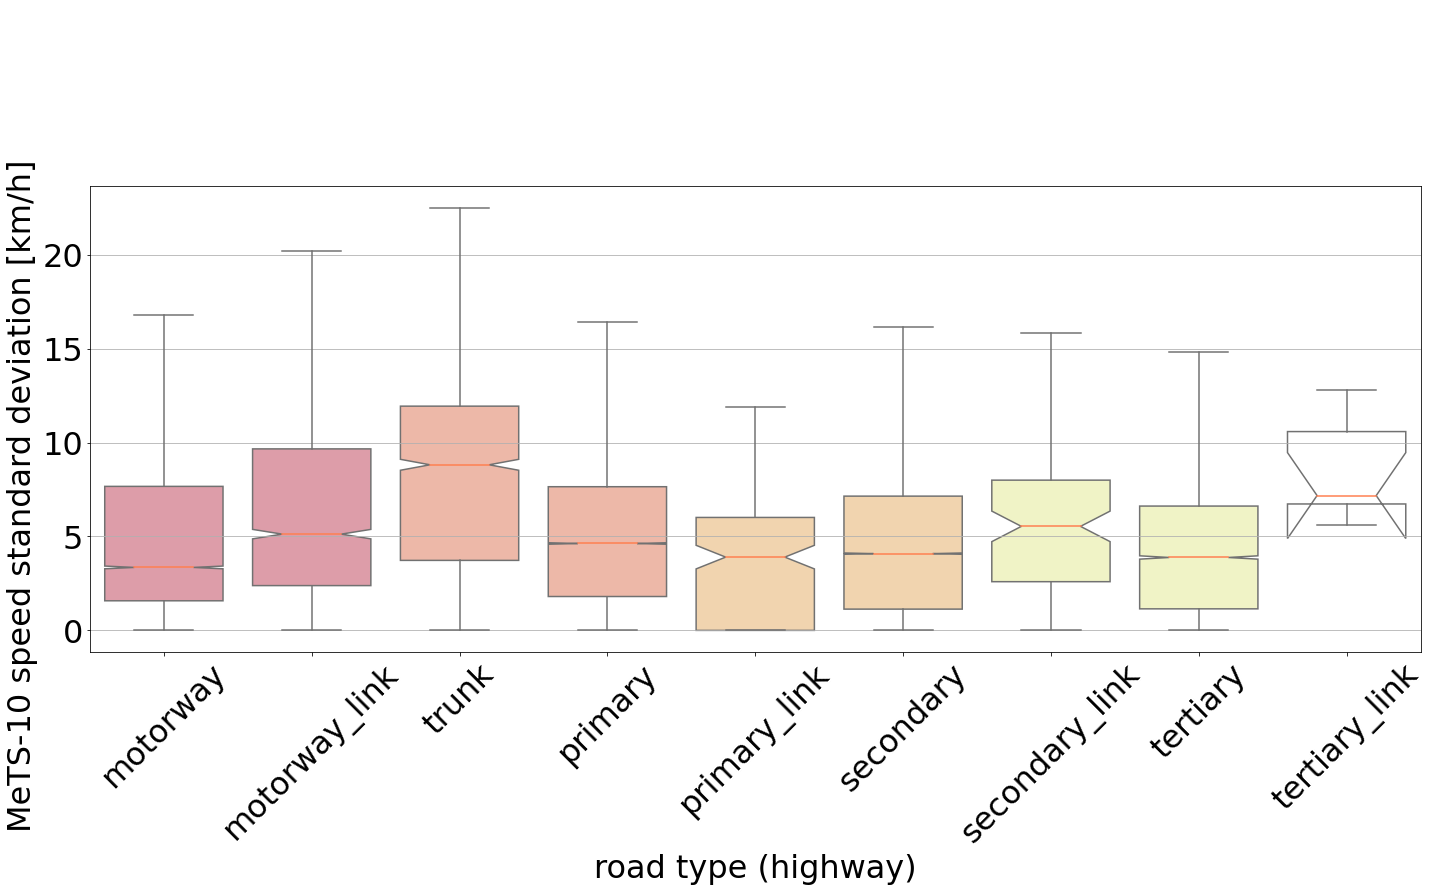

In [33]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="std_speed_kph",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='MeTS-10 speed standard deviation [km/h]               ')
#  t4c: higher stds in link classes than in the corresponding road class they link -> plausibily, they get probes from the higher class running parallel.
plt.savefig(f"{CITY.title()}_t4c_std_speed_kph.pdf")

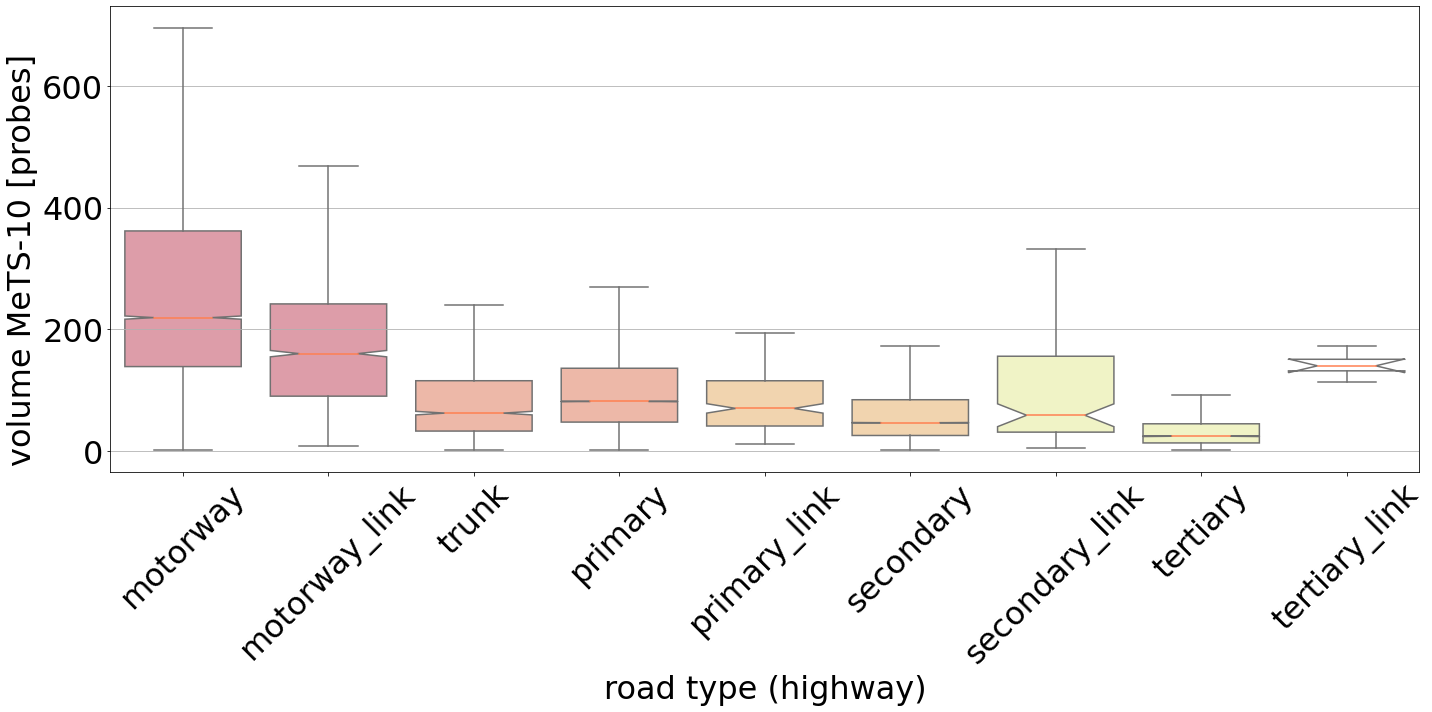

In [34]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="volume",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='volume MeTS-10 [probes]    ')
# t4c: higher volumes on links than on the class below -> plausibily, they get probes from the higher class running parallel.
plt.savefig(f"{CITY.title()}_t4c_volume.pdf")

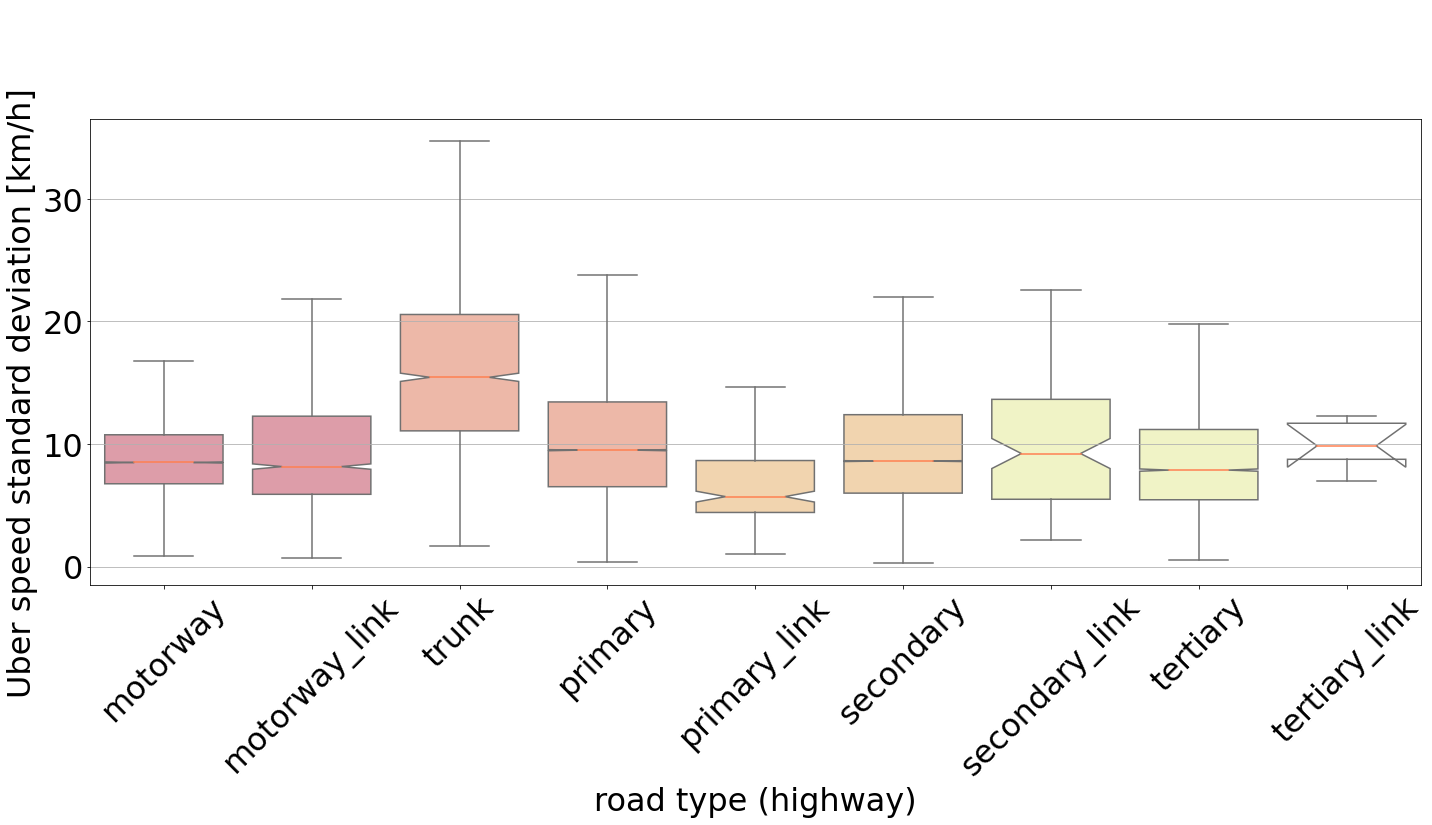

In [35]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="speed_kph_stddev",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='Uber speed standard deviation [km/h]        ')

# Uber: link class have higher std than the class they link to (apart from motorway) -> acceleration/deceleration on links plausible
plt.savefig(f"{CITY.title()}_Uber_speed_mph_stddev.pdf")

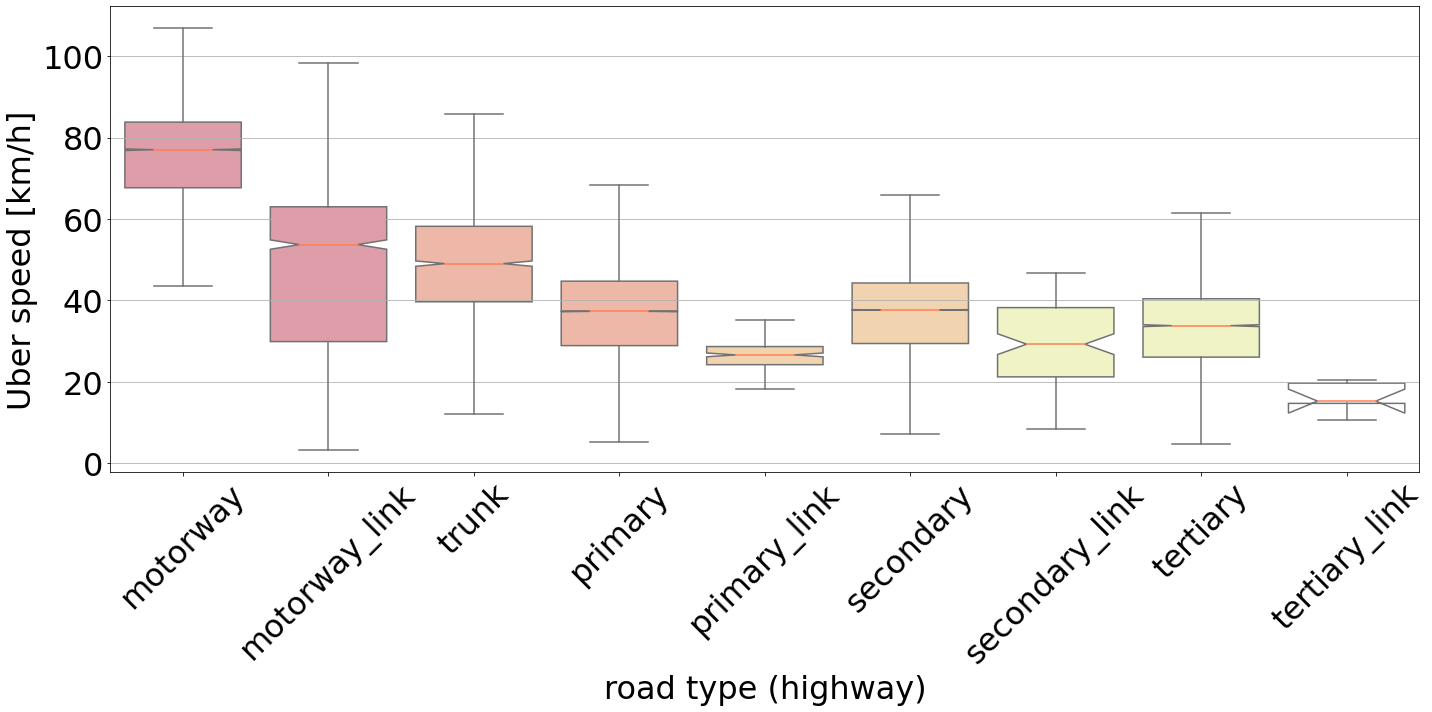

In [36]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
# sns.boxplot(ut_merged, x='highway', y='speed_kph_mean', ax=ax, palette=osm_color_palette())
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="speed_kph_mean",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='Uber speed [km/h]    ')
plt.savefig(f"{CITY.title()}_Uber_speed_kph_mean.pdf")

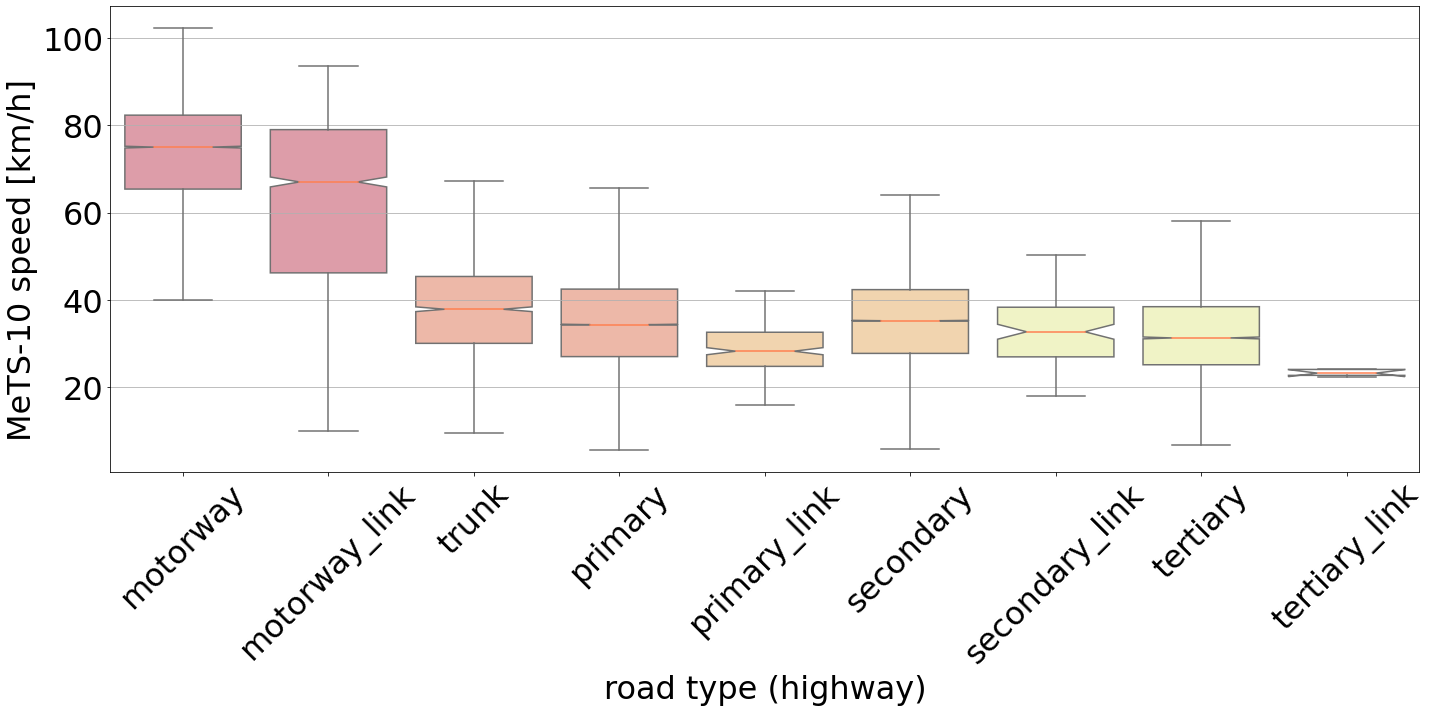

In [37]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
# sns.boxplot(ut_merged, x='highway', y='speed_kph_mean', ax=ax, palette=osm_color_palette())
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="median_speed_kph",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='MeTS-10 speed [km/h]    ')
plt.savefig(f"{CITY.title()}_Uber_median_speed_kph.pdf")

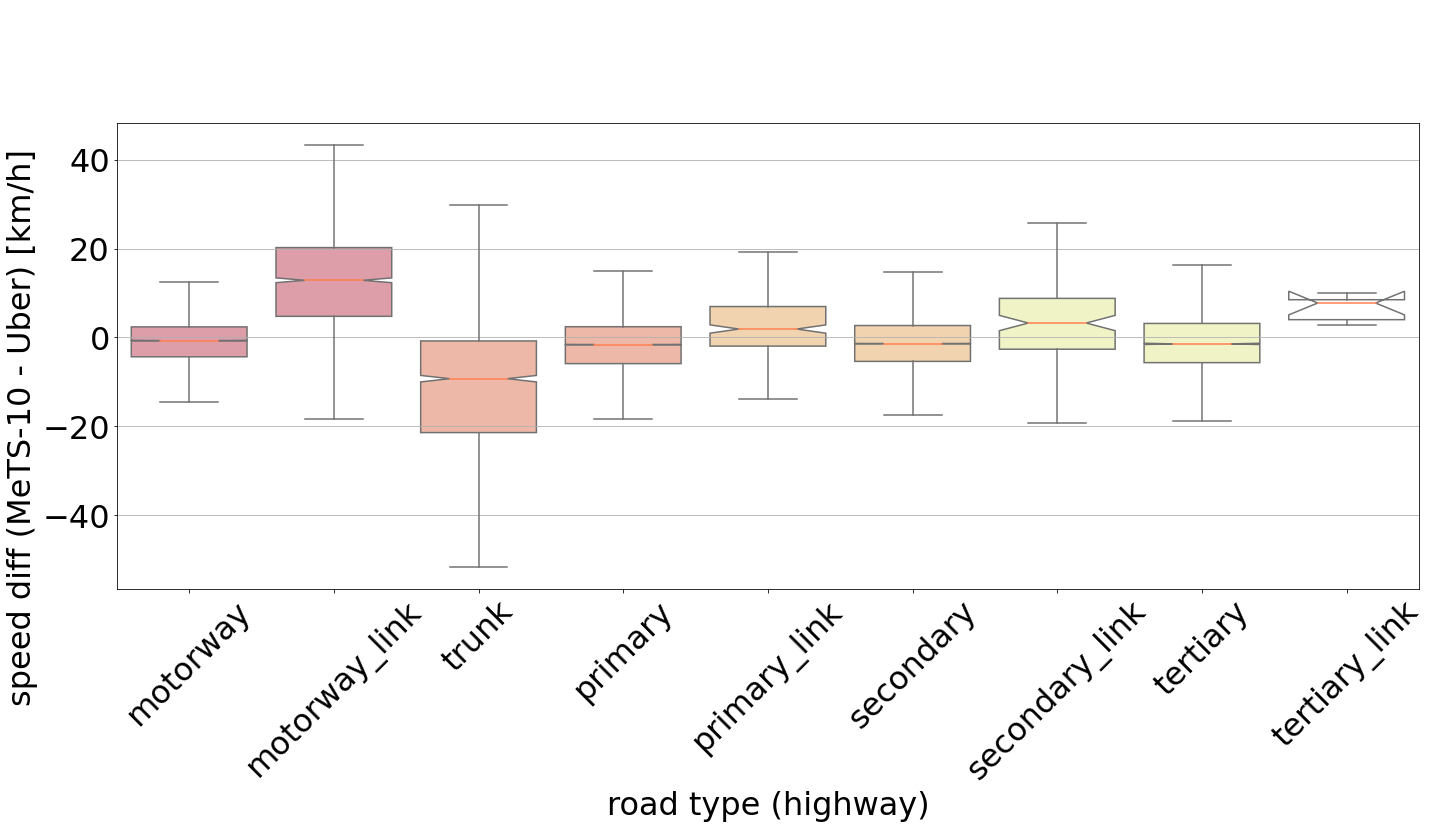

In [38]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(
    ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
    x="highway",
    y="speed_diff",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)

ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='speed diff (MeTS-10 - Uber) [km/h]              ')
plt.savefig(f"{CITY.title()}_Uber_speed_diff.pdf")

In [39]:
tspeeds_df.columns

Index(['u', 'v', 'gkey', 'year', 'month', 'day', 'hour', 'volume_class',
       'volume', 'std_speed_kph', 'median_speed_kph', 'free_flow_kph'],
      dtype='object')

In [40]:
def plot_dayline(u, v, day):
    fig, ax = plt.subplots(1, figsize=(10, 5), tight_layout=True, sharex=True, sharey=True)
    ax2 = ax.twinx()

    t_data = tspeeds_df[(tspeeds_df["u"] == u) & (tspeeds_df["v"] == v) & (tspeeds_df["day"] == day)].sort_values("hour")
    sns.lineplot(t_data, x="hour", y="median_speed_kph", ax=ax, color="orange")
    sns.lineplot(t_data, x="hour", y="volume", ax=ax, color="red")
    ax.errorbar(t_data["hour"], t_data["median_speed_kph"], yerr=t_data["std_speed_kph"], capsize=2, capthick=0.5, color="orange", linewidth=0.5, linestyle=":")

    u_data = uspeeds_df[(uspeeds_df["u"] == u) & (uspeeds_df["v"] == v) & (uspeeds_df["day"] == day)].sort_values("hour")
    sns.lineplot(u_data, x="hour", y="speed_kph_mean", ax=ax2, color="blue")
    ax.errorbar(u_data["hour"], u_data["speed_kph_mean"], yerr=u_data["speed_kph_stddev"], capsize=2, capthick=0.5, color="blue", linewidth=0.5, linestyle=":")
    rec = df_edges[(df_edges["u"] == u) & (df_edges["v"] == v)].iloc[0]
    [min([u_data["speed_kph_mean"].min(), t_data["median_speed_kph"].min()]), max([u_data["speed_kph_mean"].max(), t_data["median_speed_kph"].max()])]
    ax.set_ylim([0, 120])
    ax2.set_ylim([0, 120])
    #     ax.legend()
    #     print(rec)
    plt.title(f"{rec['name']}, {rec['highway']} {rec['length_meters']:.2f}m")

In [41]:
# (489, 359, 0, "#1_highway_outskirts", 6.783333333333333, 6.677636807534042, 186.46166666666667, 101.5549696661316),
# (329, 92, 0, "#2_highway_main_ringroad", 16.795, 15.11932822949189, 159.69333333333333, 44.37354517177),
# (345, 262, 0, "#3_boulevard_center", 12.574444444444444, 43.149366059747074, 46.68611111111111, 43.55855352139867),
# (494, 62, 2, "#4_speed_top_center_medium_mean_high_std", 2.7822222222222224, 3.4803121755822812, 137.87277777777777, 108.55130345220569),
# (359, 416, 3, "#5_speed_bottom_left_low_mean_low_std", 0.043333333333333335, 0.7251896303726199, 0.2288888888888889, 3.6858360861981363),
# (319, 307, 0, "#6_speed_std_40_60", 5.666666666666667, 7.3536838840588095, 82.935, 54.94983265063959),

In [42]:
TBASEPATH

PosixPath('/iarai/public/t4c/data_pipeline/release20221028_historic_uber')

In [43]:
df_intersecting_cells = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_intersecting_cells.parquet")
df_intersecting_cells["intersecting_cells"] = [ast.literal_eval(ic) for ic in df_intersecting_cells["intersecting_cells"]]
df_intersecting_cells

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name,geometry_reversed,intersecting_cells
0,172546_530313_24295532,172546,530313,24295532,50.0,50,secondary,,,,46.759468,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd8\xbc...,Emmentaler Straße,False,"[(286, 163, 0, 1.0)]"
1,172558_172559_160130963,172558,172559,160130963,50.0,50,primary,,,,164.463017,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xbepB|\...,Müllerstraße,False,"[(294, 147, 1, 0.7021122973989331), (295, 148,..."
2,172559_29688040_160130963,172559,29688040,160130963,50.0,50,primary,,,,153.966487,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x0f\x14...,Müllerstraße,False,"[(293, 145, 1, 0.10916459105032425), (293, 146..."
3,172562_530351_4804203,172562,530351,4804203,50.0,50,primary_link,,,,23.283372,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd3\xe8...,,False,"[(291, 141, 3, 1.0)]"
4,172564_530185_4432669,172564,530185,4432669,50.0,50,secondary,,,,44.345716,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xc9I\x1...,Kurt-Schumacher-Platz,False,"[(289, 138, 3, 0.17365008160005327), (290, 138..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16274,6171409045_6171409044_71143837,6171409045,6171409044,71143837,50.0,50,secondary,,,,71.576136,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x7f\xd9...,Axel-Springer-Straße,False,"[(345, 210, 0, 1.0)]"
16275,6172685050_26745400_417807344,6172685050,26745400,417807344,50.0,50,residential,,,,5.821343,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xfbn\x0...,Bendlerbrücke,False,"[(348, 173, 0, 1.0)]"
16276,6172693100_26746095_16943617,6172693100,26746095,16943617,30.0,30,primary,,,,9.151821,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00z\xbbo\x...,Potsdamer Straße,False,"[(348, 179, 3, 1.0)]"
16277,6173378369_426425009_132105452,6173378369,426425009,132105452,50.0,50,tertiary,,,,3.764184,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd8R\xf...,Lückstraße,False,"[(352, 303, 2, 0.5120481927622961), (352, 302,..."


In [44]:
def find_edges(row, col, heading=0):
    found = []
    for gkey, ic in zip(df_intersecting_cells["gkey"], df_intersecting_cells["intersecting_cells"]):
        #         print(ic)
        #         print(type(ic))
        for r, c, h, _ in ic:

            if row == r and col == c and h == heading:
                found.append(gkey)
    print(found)
    for gkey in found:
        print(gkey)
        u, v, w = gkey.split("_")
        print(f"https://www.openstreetmap.org/node/{u}")
        print(f"https://www.openstreetmap.org/node/{v}")
        print(f"https://www.openstreetmap.org/way/{w}")
    return found

In [45]:
find_edges(489, 359)

[]


[]

### #3_boulevard_center

In [46]:
find_edges(345, 262)

['29785111_29785113_61737905', '1822678314_29785111_260235997']
29785111_29785113_61737905
https://www.openstreetmap.org/node/29785111
https://www.openstreetmap.org/node/29785113
https://www.openstreetmap.org/way/61737905
1822678314_29785111_260235997
https://www.openstreetmap.org/node/1822678314
https://www.openstreetmap.org/node/29785111
https://www.openstreetmap.org/way/260235997


['29785111_29785113_61737905', '1822678314_29785111_260235997']

In [47]:
# 29785111_29785113_61737905
u = 29785111
v = 29785113

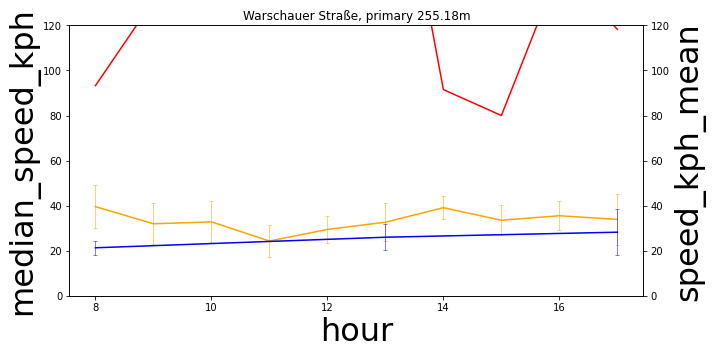

In [48]:
plot_dayline(u=u, v=v, day=1)

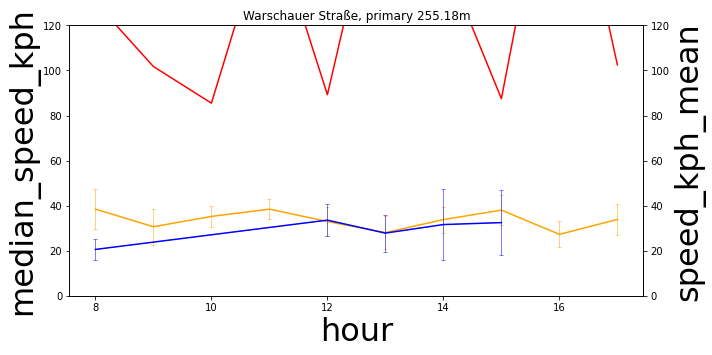

In [49]:
plot_dayline(u=u, v=v, day=2)

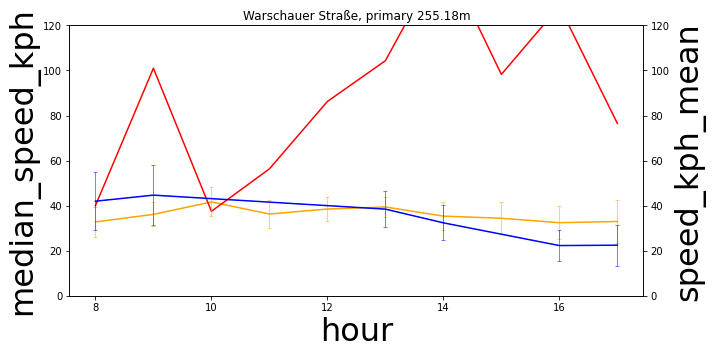

In [50]:
plot_dayline(u=u, v=v, day=3)

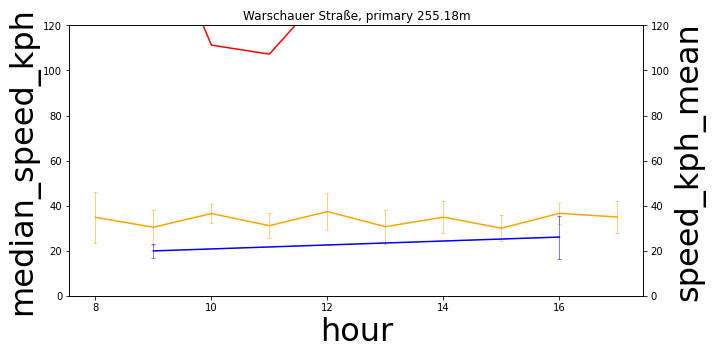

In [51]:
plot_dayline(u=u, v=v, day=4)

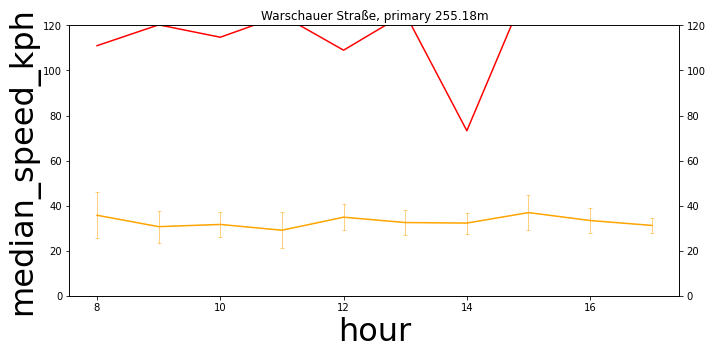

In [52]:
plot_dayline(u=u, v=v, day=5)

###        #2_highway_main_ringroad"

In [53]:
find_edges(329, 92)

['458345_267209693_4764112', '1020330210_458345_328440044']
458345_267209693_4764112
https://www.openstreetmap.org/node/458345
https://www.openstreetmap.org/node/267209693
https://www.openstreetmap.org/way/4764112
1020330210_458345_328440044
https://www.openstreetmap.org/node/1020330210
https://www.openstreetmap.org/node/458345
https://www.openstreetmap.org/way/328440044


['458345_267209693_4764112', '1020330210_458345_328440044']

In [54]:
u = 1020330210
v = 458345

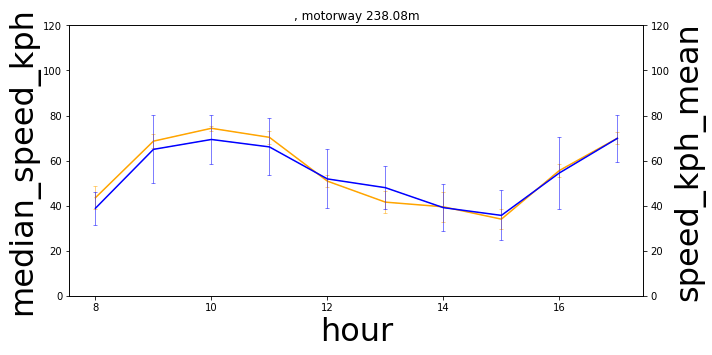

In [55]:
plot_dayline(u=u, v=v, day=1)

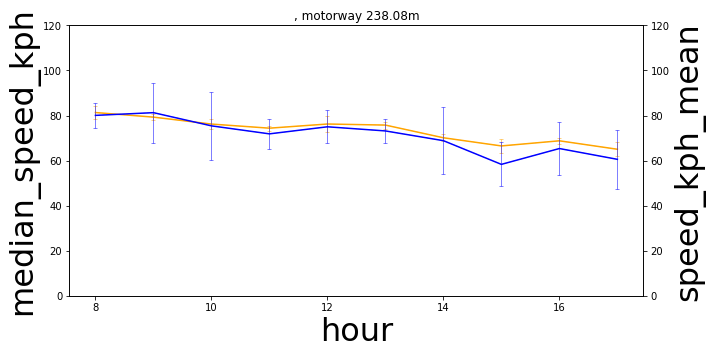

In [56]:
plot_dayline(u=u, v=v, day=2)

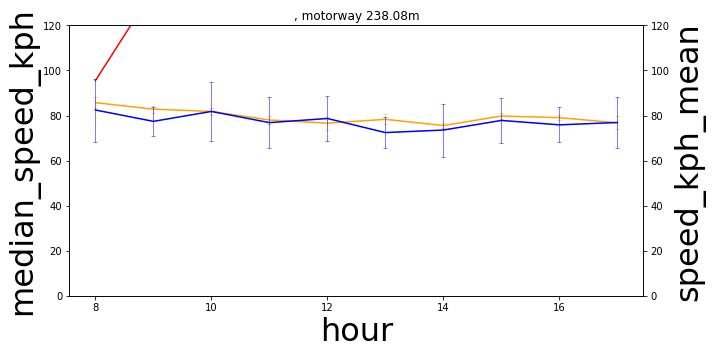

In [57]:
plot_dayline(u=u, v=v, day=3)

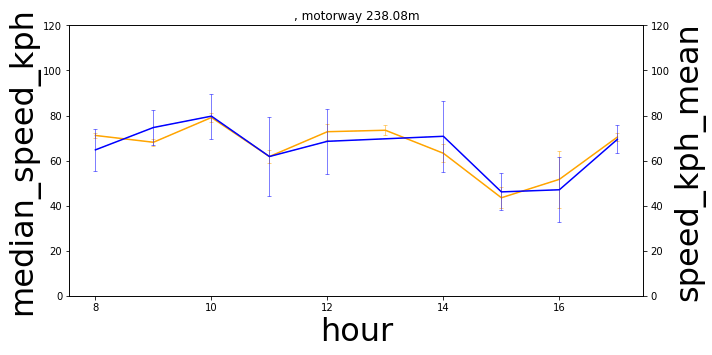

In [58]:
plot_dayline(u=u, v=v, day=4)

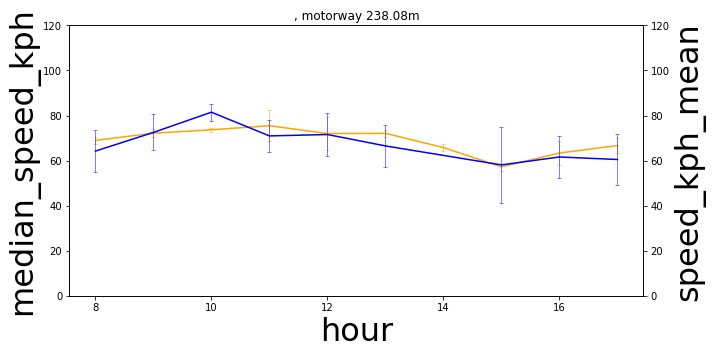

In [59]:
plot_dayline(u=u, v=v, day=5)

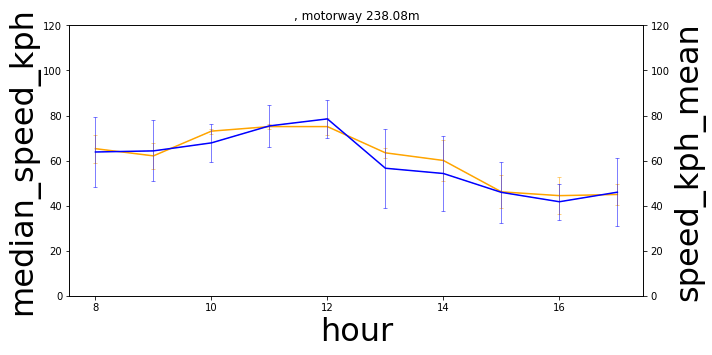

In [60]:
# Saturday
plot_dayline(u=u, v=v, day=6)

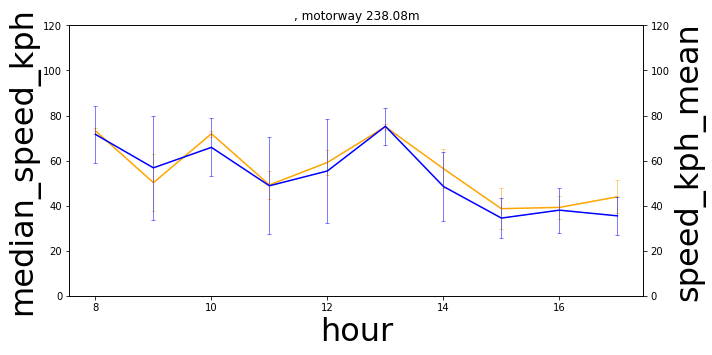

In [61]:
plot_dayline(u=u, v=v, day=7)

### #1_highway_outskirts

In [62]:
find_edges(489, 359)

[]


[]

###  #4_speed_top_center_medium_mean_high_std

In [63]:
find_edges(494, 62, 2)

[]


[]

### #5_speed_bottom_left_low_mean_low_std

In [64]:
find_edges(359, 416, 3)

[]


[]

### #6_speed_std_40_60

In [65]:
find_edges(319, 307, 0)

['30694259_4313424145_432205789', '3328122222_30694259_432205789']
30694259_4313424145_432205789
https://www.openstreetmap.org/node/30694259
https://www.openstreetmap.org/node/4313424145
https://www.openstreetmap.org/way/432205789
3328122222_30694259_432205789
https://www.openstreetmap.org/node/3328122222
https://www.openstreetmap.org/node/30694259
https://www.openstreetmap.org/way/432205789


['30694259_4313424145_432205789', '3328122222_30694259_432205789']

In [66]:
u = 3328122222
v = 30694259

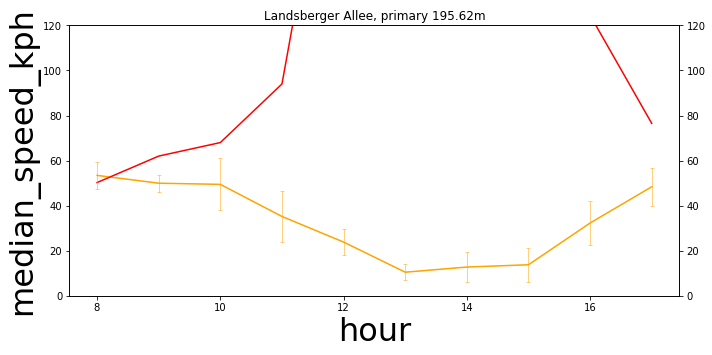

In [67]:
plot_dayline(u=u, v=v, day=1)

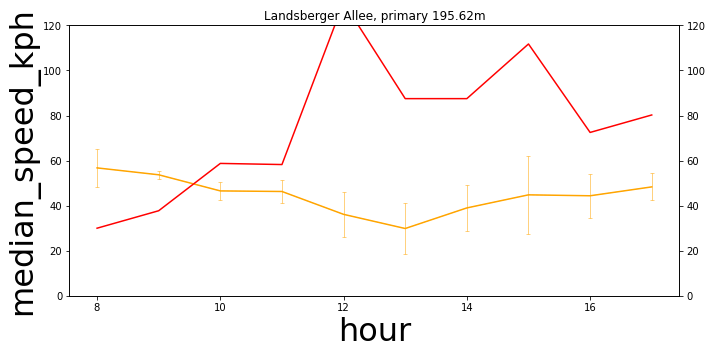

In [68]:
plot_dayline(u=u, v=v, day=2)

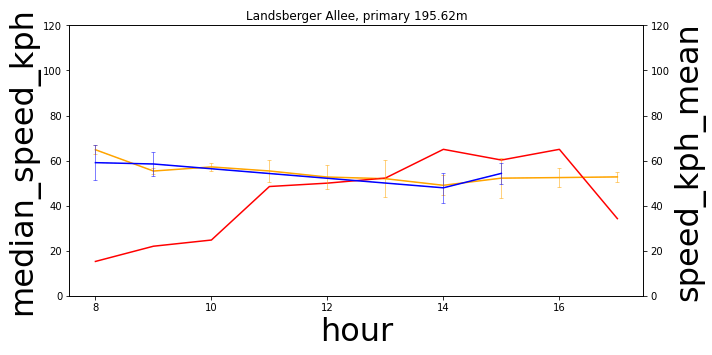

In [69]:
plot_dayline(u=u, v=v, day=3)

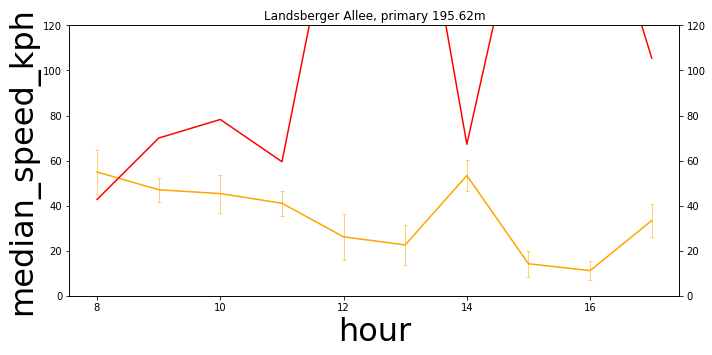

In [70]:
plot_dayline(u=u, v=v, day=4)

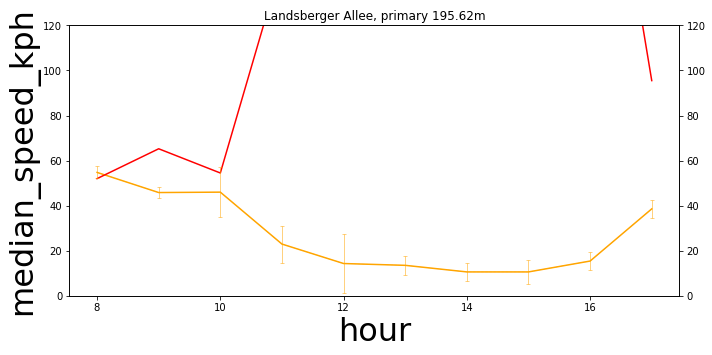

In [71]:
plot_dayline(u=u, v=v, day=5)

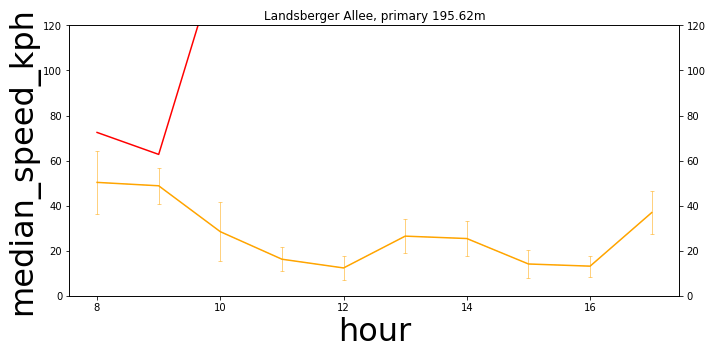

In [72]:
plot_dayline(u=u, v=v, day=6)

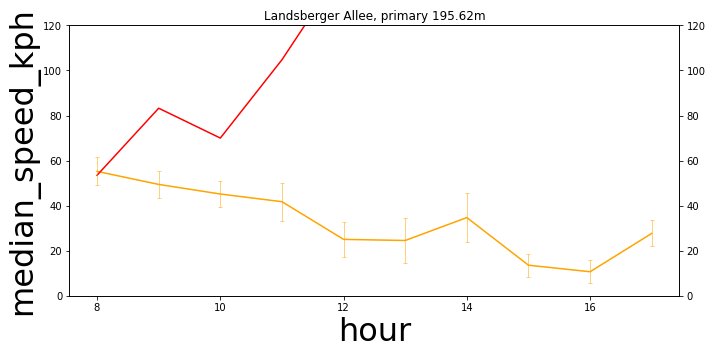

In [73]:
plot_dayline(u=u, v=v, day=7)

## KDE

/home/che/miniconda3/envs/t4c22/lib/python3.9/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


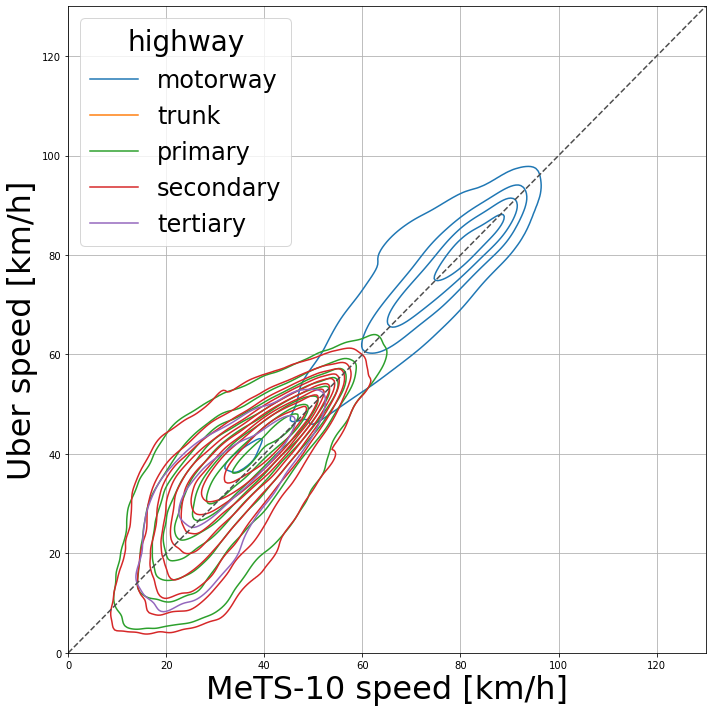

In [74]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 10))
sns.kdeplot(
    data=ut_merged[[simplified_filter(hw) and "link" not in hw for hw in ut_merged["highway"]]], x="median_speed_kph", y="speed_kph_mean", hue="highway", ax=ax
)
ax.plot([0, 130], [0, 130], ls="--", c=".3")
ax.set_xlim([0, 130])
ax.set_ylim([0, 130])
ax.grid(axis="both")
ax.set(xlabel='MeTS-10 speed [km/h]',
       ylabel='Uber speed [km/h]')
plt.savefig(f"{CITY.title()}_Uber_kde_highway_non_links.pdf")

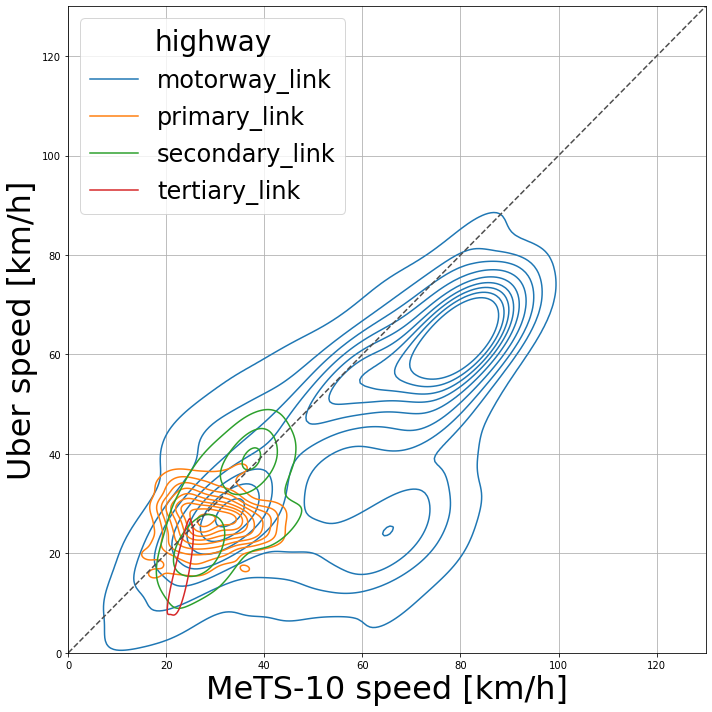

In [75]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 10))
sns.kdeplot(
    data=ut_merged[[simplified_filter(hw) and "link" in hw for hw in ut_merged["highway"]]], x="median_speed_kph", y="speed_kph_mean", hue="highway", ax=ax
)
ax.plot([0, 130], [0, 130], ls="--", c=".3")
ax.set_xlim([0, 130])
ax.set_ylim([0, 130])
ax.grid(axis="both")
ax.set(xlabel='MeTS-10 speed [km/h]',
       ylabel='Uber speed [km/h]')
plt.savefig(f"{CITY.title()}_Uber_kde_highway_links.pdf")

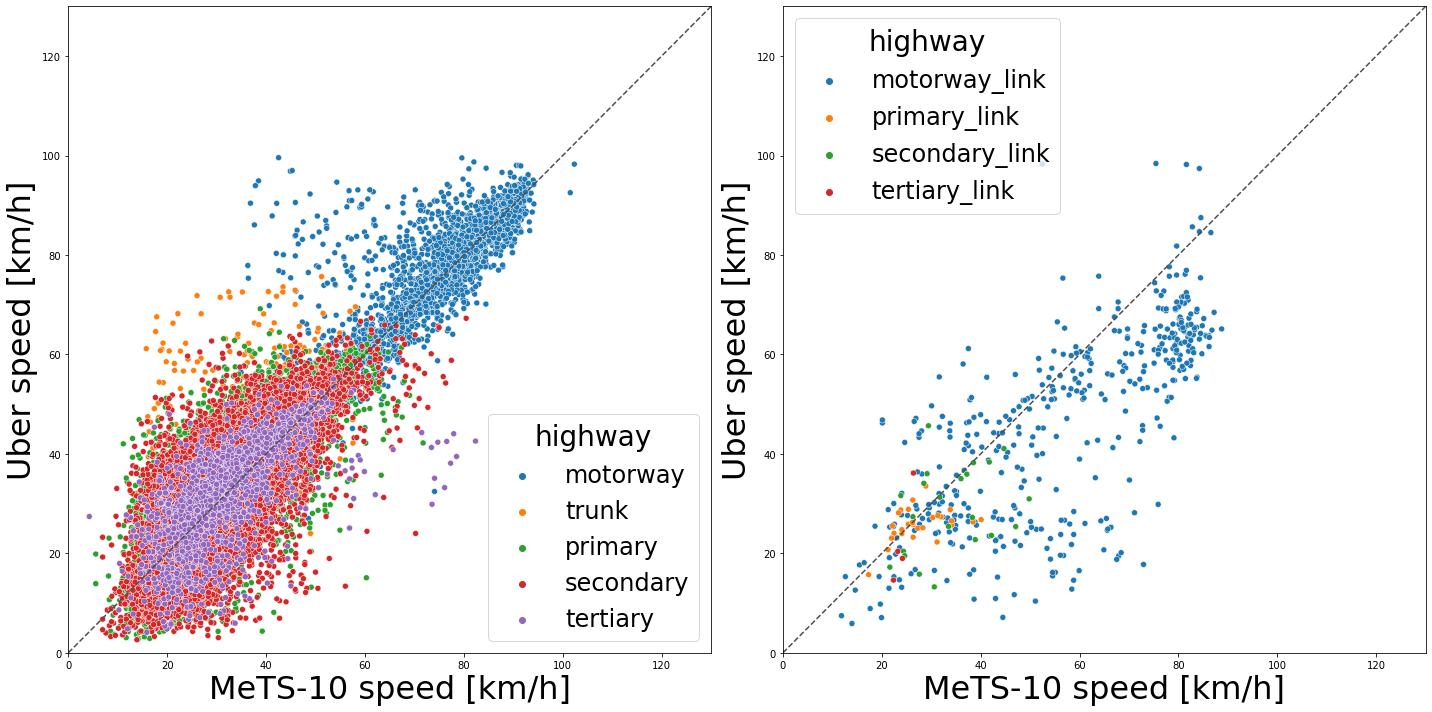

In [102]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
ax0, ax1 = axs
sns.scatterplot(
    data=ut_merged[[simplified_filter(hw) and "link" not in hw for hw in ut_merged["highway"]] & (ut_merged["day"] == END_DAY)],
    x="median_speed_kph",
    y="speed_kph_mean",
    hue="highway",
    ax=ax0,
)
sns.scatterplot(
    data=ut_merged[[simplified_filter(hw) and "link" in hw for hw in ut_merged["highway"]] & (ut_merged["day"] == END_DAY)],
    x="median_speed_kph",
    y="speed_kph_mean",
    hue="highway",
    ax=ax1,
)

for ax in axs:
    ax.plot([0, 130], [0, 130], ls="--", c=".3")
    ax.set_xlim([0, 130])
    ax.set_ylim([0, 130])
    ax.set(xlabel='MeTS-10 speed [km/h]',
       ylabel='Uber speed [km/h]')
plt.savefig(f"{CITY.title()}_Uber_scatter_highway.png")

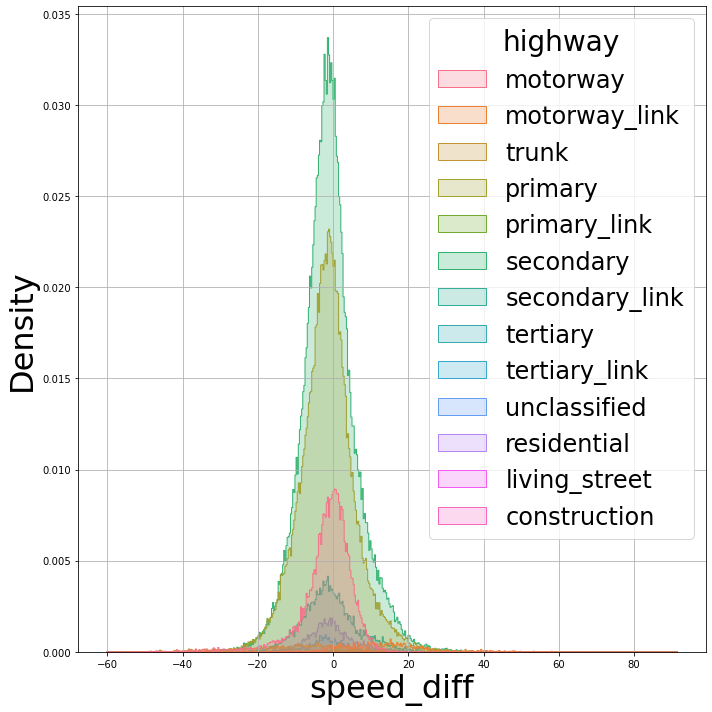

In [77]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 10))
sns.histplot(data=ut_merged, x="speed_diff", hue="highway", element="step", stat="density")
# ax.set_yscale('log')
ax.grid()
plt.savefig(f"{CITY.title()}_Uber_histogram_highway.pdf")

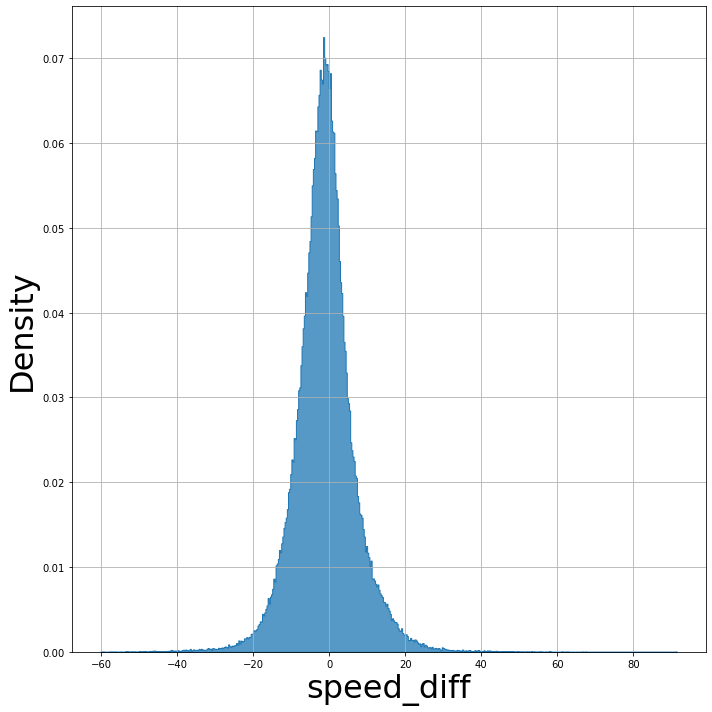

In [78]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 10))
sns.histplot(
    data=ut_merged,
    x="speed_diff"
    #              , hue="highway"
    ,
    element="step",
    stat="density",
)
# ax.set_yscale('log')
ax.grid()
plt.savefig(f"{CITY.title()}_Uber_histogram.pdf")

## Inspect extreme cases (speed_diff > 20)

In [79]:
df_cell_mapping = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_intersecting_cells.parquet")
df_cell_mapping

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name,geometry_reversed,intersecting_cells
0,172546_530313_24295532,172546,530313,24295532,50.0,50,secondary,,,,46.759468,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd8\xbc...,Emmentaler Straße,False,"[(286, 163, 0, 1.0)]"
1,172558_172559_160130963,172558,172559,160130963,50.0,50,primary,,,,164.463017,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xbepB|\...,Müllerstraße,False,"[(294, 147, 1, 0.7021122973989331), (295, 148,..."
2,172559_29688040_160130963,172559,29688040,160130963,50.0,50,primary,,,,153.966487,b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\x0f\x14...,Müllerstraße,False,"[(293, 145, 1, 0.10916459105032425), (293, 146..."
3,172562_530351_4804203,172562,530351,4804203,50.0,50,primary_link,,,,23.283372,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd3\xe8...,,False,"[(291, 141, 3, 1.0)]"
4,172564_530185_4432669,172564,530185,4432669,50.0,50,secondary,,,,44.345716,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xc9I\x1...,Kurt-Schumacher-Platz,False,"[(289, 138, 3, 0.17365008160005327), (290, 138..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16274,6171409045_6171409044_71143837,6171409045,6171409044,71143837,50.0,50,secondary,,,,71.576136,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\x7f\xd9...,Axel-Springer-Straße,False,"[(345, 210, 0, 1.0)]"
16275,6172685050_26745400_417807344,6172685050,26745400,417807344,50.0,50,residential,,,,5.821343,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xfbn\x0...,Bendlerbrücke,False,"[(348, 173, 0, 1.0)]"
16276,6172693100_26746095_16943617,6172693100,26746095,16943617,30.0,30,primary,,,,9.151821,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00z\xbbo\x...,Potsdamer Straße,False,"[(348, 179, 3, 1.0)]"
16277,6173378369_426425009_132105452,6173378369,426425009,132105452,50.0,50,tertiary,,,,3.764184,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xd8R\xf...,Lückstraße,False,"[(352, 303, 2, 0.5120481927622961), (352, 302,..."


In [80]:
cols = [
    "year",
    "month",
    "day",
    "hour",
    "speed_diff",
    "std_speed_kph",
    "median_speed_kph",
    "speed_kph_mean",
    "free_flow_kph",
    "speed_kph",
    "length_meters",
    "x_u",
    "y_u",
    "x_v",
    "y_v",
]

extreme_edges = (
    ut_merged[ut_merged["speed_diff"] > 10]
    .groupby(["u", "v", "gkey"])
    .agg(**{col: (col, "mean") for col in cols}, count=("year", "count"), name=("name", "first"))
    .reset_index()[cols + ["name", "count", "u", "v", "gkey"]]
    .sort_values("speed_diff", ascending=False)
)
extreme_edges = extreme_edges[extreme_edges["count"] > 1]
extreme_edges

,year,month,day,hour,speed_diff,std_speed_kph,median_speed_kph,speed_kph_mean,free_flow_kph,speed_kph,length_meters,x_u,y_u,x_v,y_v,name,count,u,v,gkey
1671,2019.0,2.0,3.166667,12.000000,58.090810,14.146627,78.776144,20.685333,87.764706,60.0,105.958808,13.518392,52.398447,13.518459,52.397469,,6,1641539256,1641539237,1641539256_1641539237_322481077
1670,2019.0,2.0,2.750000,11.750000,57.810966,13.428922,64.914216,7.103250,85.490196,60.0,31.189818,13.518459,52.397469,13.518521,52.397188,,4,1641539237,1641539234,1641539237_1641539234_322481076
955,2019.0,2.0,6.666667,9.333333,49.279176,0.000000,78.941176,29.662000,96.000000,30.0,35.082485,13.260221,52.489247,13.260470,52.489446,Eichkampstraße,3,139983430,26838155,139983430_26838155_26614075
956,2019.0,2.0,6.666667,9.333333,44.566915,14.065181,79.954248,35.387333,98.196078,30.0,59.088470,13.259800,52.488914,13.260221,52.489247,Eichkampstraße,3,139983491,139983430,139983491_139983430_28829859
59,2019.0,2.0,1.750000,10.250000,43.575985,28.610093,67.338235,23.762250,85.019608,60.0,343.304487,13.389534,52.469346,13.386517,52.470020,,4,21487279,1565834567,21487279_1565834567_4493097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931,2019.0,2.0,6.500000,13.500000,10.231716,2.350955,53.039216,42.807500,51.450980,50.0,77.884676,13.411502,52.518644,13.412094,52.519028,Grunerstraße,2,2548947450,2933662031,2548947450_2933662031_289966281
404,2019.0,2.0,6.000000,11.000000,10.207510,6.039216,17.274510,7.067000,25.568627,50.0,50.241796,13.333587,52.505207,13.334002,52.505390,Kantstraße,2,26787978,20246271,26787978_20246271_327462542
2529,2019.0,2.0,6.500000,16.000000,10.194882,8.238229,36.205882,26.011000,46.117647,50.0,109.715556,13.310912,52.500322,13.311894,52.500425,Kurfürstendamm,2,4825253643,26704550,4825253643_26704550_490345043
221,2019.0,2.0,6.000000,11.500000,10.168938,7.360220,39.511438,29.342500,47.058824,50.0,251.451605,13.321770,52.493022,13.319622,52.492293,Hohenzollerndamm,2,26731176,60668470,26731176_60668470_520627748


In [81]:
def show_marker_on_map(lat, lon, lat2, lon2):
    pt = (lat, lon)
    pt2 = (lat2, lon2)
    bb = [(lat - 0.001, lon - 0.001), (lat + 0.001, lon + 0.001)]
    f = folium.Figure(width=930, height=300)
    m = folium.Map().add_to(f)
    folium.Marker(pt).add_to(m)
    folium.Marker(pt2).add_to(m)
    # folium.PolyLine(line, weight=5, opacity=1).add_to(m)
    m.fit_bounds(bb)
    return m


def visualize_extreme_case(i, extreme_edges=extreme_edges):
    item = extreme_edges.iloc[i]
    print(item)
    print("intersecting_cells")
    ic = df_cell_mapping[(df_cell_mapping["gkey"] == item["gkey"])]
    assert len(ic) == 1
    ic = ic.iloc[0]
    for ic in ast.literal_eval(ic["intersecting_cells"]):
        print(f"  {ic}")
    fig, ax = plt.subplots(1, tight_layout=True, figsize=(20, 10))
    data = ut_merged[(ut_merged["u"] == item["u"]) & (ut_merged["v"] == item["v"]) & (ut_merged["gkey"] == item["gkey"])]
    ax.plot(range(len(data)), data["median_speed_kph"], label="median_speed_kph", color="red")
    ax.plot(range(len(data)), data["speed_kph_mean"], label="speed_kph_mean", color="orange")
    ax.plot(range(len(data)), data["std_speed_kph"], label="std_speed_kph", color="green")
    ax.plot(range(len(data)), data["speed_kph_stddev"], label="speed_kph_stddev", color="yellow")
    ax.axhline(item["free_flow_kph"], label="free_flow_kph", color="black")
    ax.axhline(item["speed_kph"], label="speed_kph", color="grey", linestyle="dashed")
    ax.bar(range(len(data)), data["volume"], color="blue", label="volume")
    ax.legend()
    return show_marker_on_map(item["y_u"], item["x_u"], item["y_v"], item["x_v"])

year                                         2019.0
month                                           2.0
day                                        3.166667
hour                                           12.0
speed_diff                                 58.09081
std_speed_kph                             14.146627
median_speed_kph                          78.776144
speed_kph_mean                            20.685333
free_flow_kph                             87.764706
speed_kph                                      60.0
length_meters                            105.958808
x_u                                       13.518392
y_u                                       52.398447
x_v                                       13.518459
y_v                                       52.397469
name                                               
count                                             6
u                                        1641539256
v                                        1641539237
gkey        

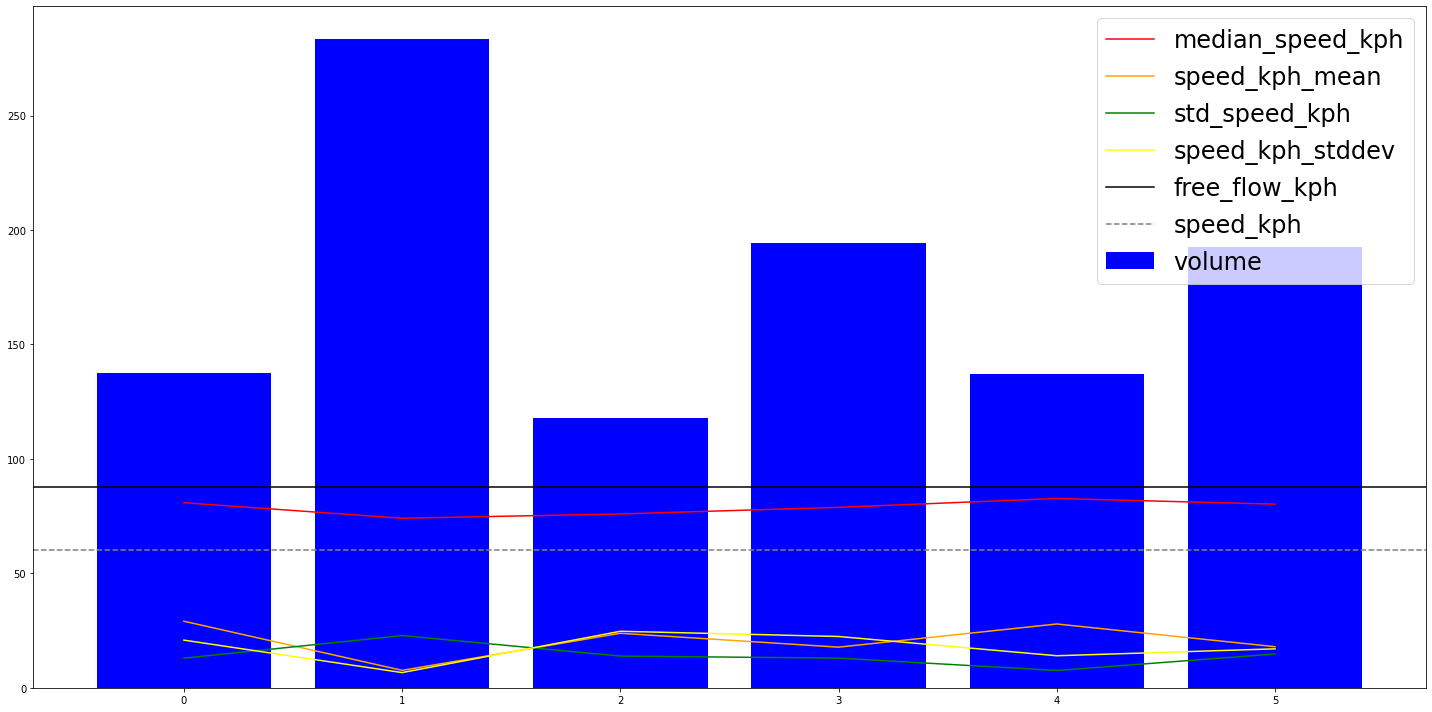

In [82]:
visualize_extreme_case(0)

year                                       2019.0
month                                         2.0
day                                         5.875
hour                                       12.375
speed_diff                              25.067681
std_speed_kph                            4.497549
median_speed_kph                        37.203431
speed_kph_mean                           12.13575
free_flow_kph                           72.470588
speed_kph                                    50.0
length_meters                           99.956022
x_u                                      13.28461
y_u                                     52.495329
x_v                                     13.285305
y_v                                     52.494743
name                               Halenseestraße
count                                           8
u                                      3833353195
v                                        26734559
gkey                3833353195_26734559_421287707


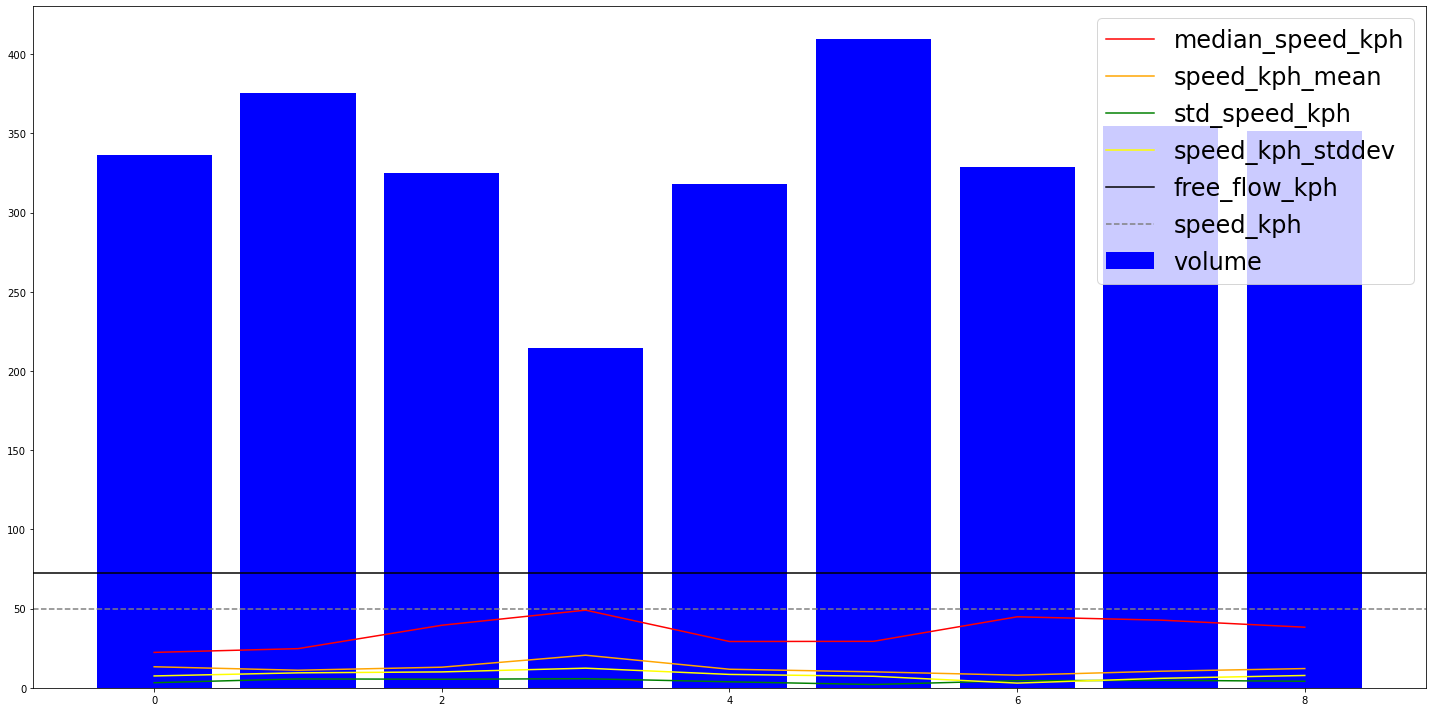

In [83]:
visualize_extreme_case(55)

year                                       2019.0
month                                         2.0
day                                         4.125
hour                                        9.625
speed_diff                              20.484216
std_speed_kph                            7.199755
median_speed_kph                        36.351716
speed_kph_mean                            15.8675
free_flow_kph                           49.411765
speed_kph                                    50.0
length_meters                           88.083725
x_u                                     13.424549
y_u                                         52.54
x_v                                     13.424141
y_v                                     52.539302
name                             Prenzlauer Allee
count                                           8
u                                       518827256
v                                       281814186
gkey                518827256_281814186_334160409


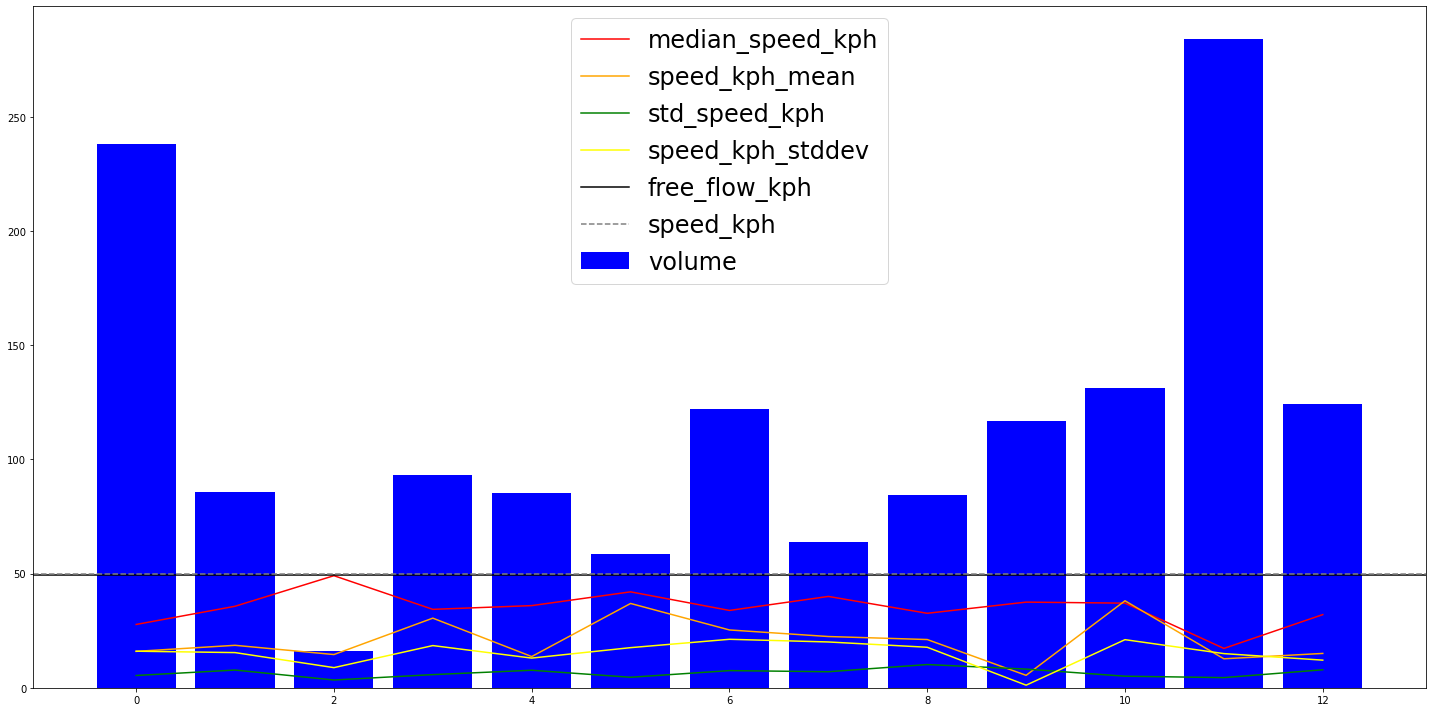

In [84]:
visualize_extreme_case(105)

year                                      2019.0
month                                        2.0
day                                     6.666667
hour                                    9.333333
speed_diff                             44.566915
std_speed_kph                          14.065181
median_speed_kph                       79.954248
speed_kph_mean                         35.387333
free_flow_kph                          98.196078
speed_kph                                   30.0
length_meters                           59.08847
x_u                                      13.2598
y_u                                    52.488914
x_v                                    13.260221
y_v                                    52.489247
name                              Eichkampstraße
count                                          3
u                                      139983491
v                                      139983430
gkey                139983491_139983430_28829859
Name: 956, dtype: ob

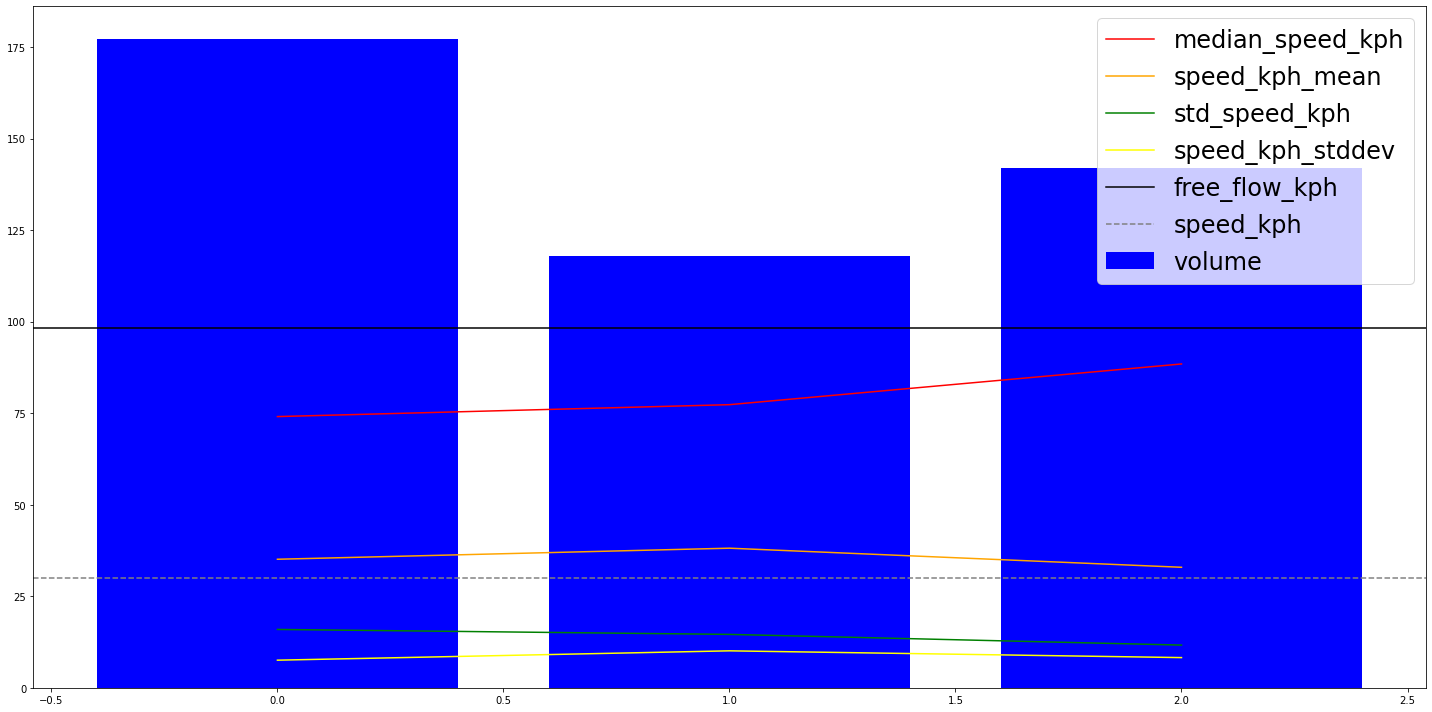

In [85]:
visualize_extreme_case(3)

year                                     2019.0
month                                       2.0
day                                        1.75
hour                                      10.25
speed_diff                            43.575985
std_speed_kph                         28.610093
median_speed_kph                      67.338235
speed_kph_mean                         23.76225
free_flow_kph                         85.019608
speed_kph                                  60.0
length_meters                        343.304487
x_u                                   13.389534
y_u                                   52.469346
x_v                                   13.386517
y_v                                    52.47002
name                                           
count                                         4
u                                      21487279
v                                    1565834567
gkey                21487279_1565834567_4493097
Name: 59, dtype: object
intersecting_cel

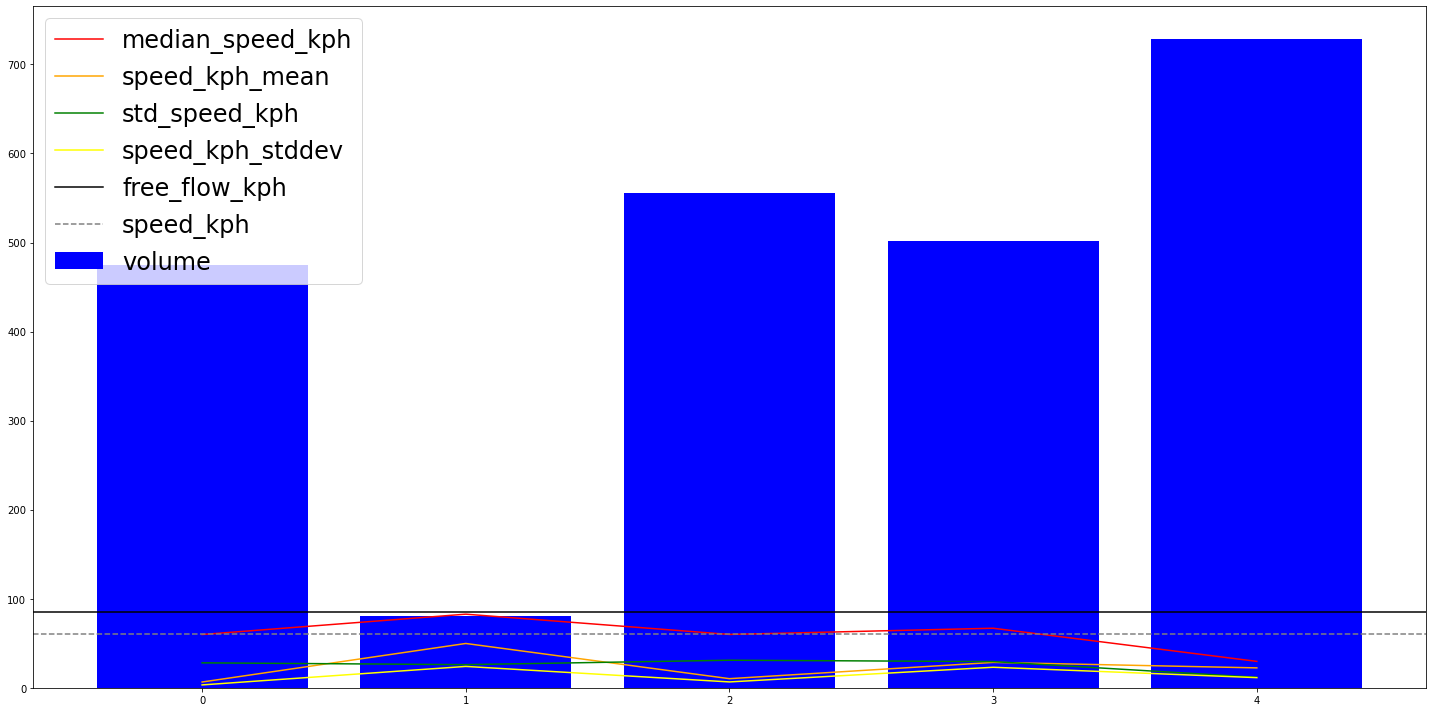

In [86]:
visualize_extreme_case(4)

year                                     2019.0
month                                       2.0
day                                    6.666667
hour                                   9.333333
speed_diff                            42.237033
std_speed_kph                          15.27919
median_speed_kph                      85.248366
speed_kph_mean                        43.011333
free_flow_kph                        101.333333
speed_kph                                  30.0
length_meters                         477.36314
x_u                                   13.256389
y_u                                   52.486235
x_v                                     13.2598
y_v                                   52.488914
name                             Eichkampstraße
count                                         3
u                                      26838149
v                                     139983491
gkey                26838149_139983491_28829858
Name: 427, dtype: object
intersecting_ce

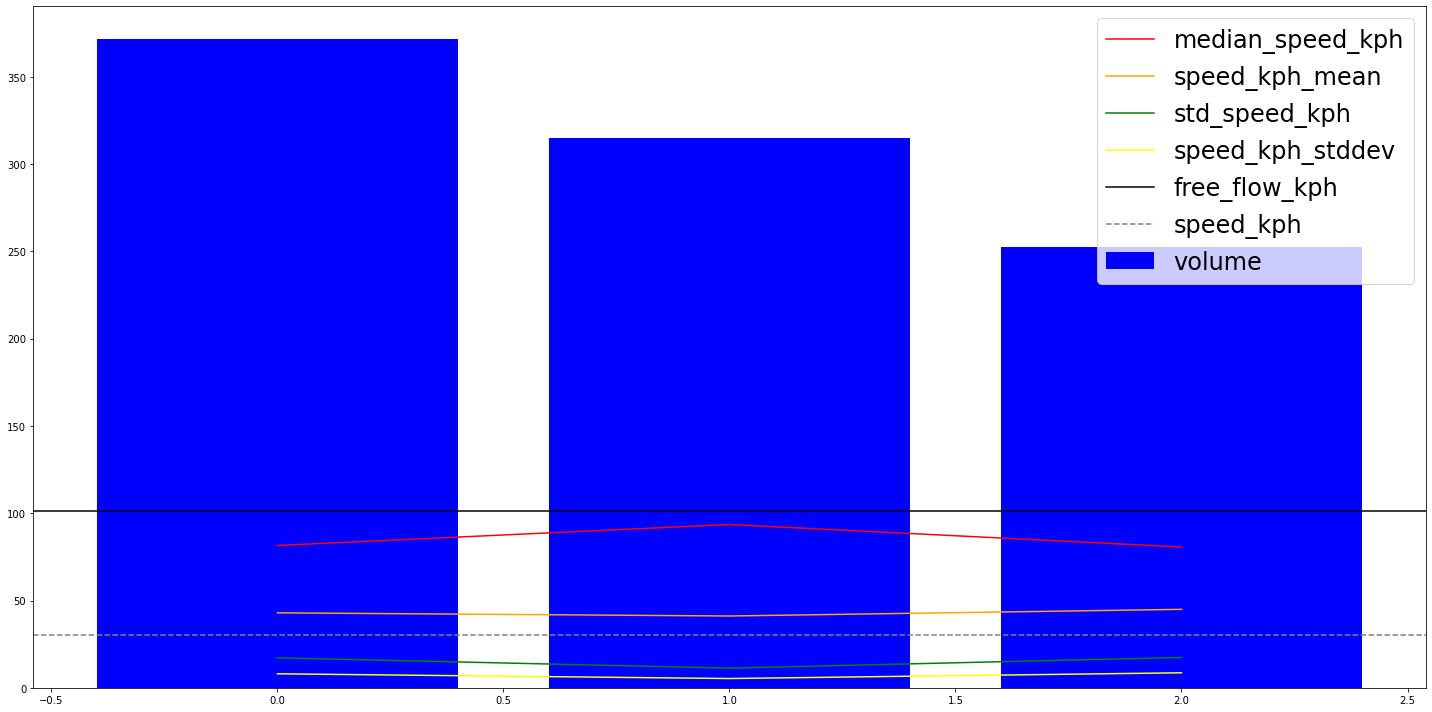

In [87]:
visualize_extreme_case(5)

year                                    2019.0
month                                      2.0
day                                   6.666667
hour                                  9.333333
speed_diff                           35.659869
std_speed_kph                         5.745037
median_speed_kph                     76.339869
speed_kph_mean                           40.68
free_flow_kph                        96.313725
speed_kph                                 30.0
length_meters                       204.448488
x_u                                  13.265427
y_u                                  52.493408
x_v                                   13.26689
y_v                                  52.494552
name                            Eichkampstraße
count                                        3
u                                     26838159
v                                     26838161
gkey                26838159_26838161_26614075
Name: 430, dtype: object
intersecting_cells
  (360, 77, 0, 0

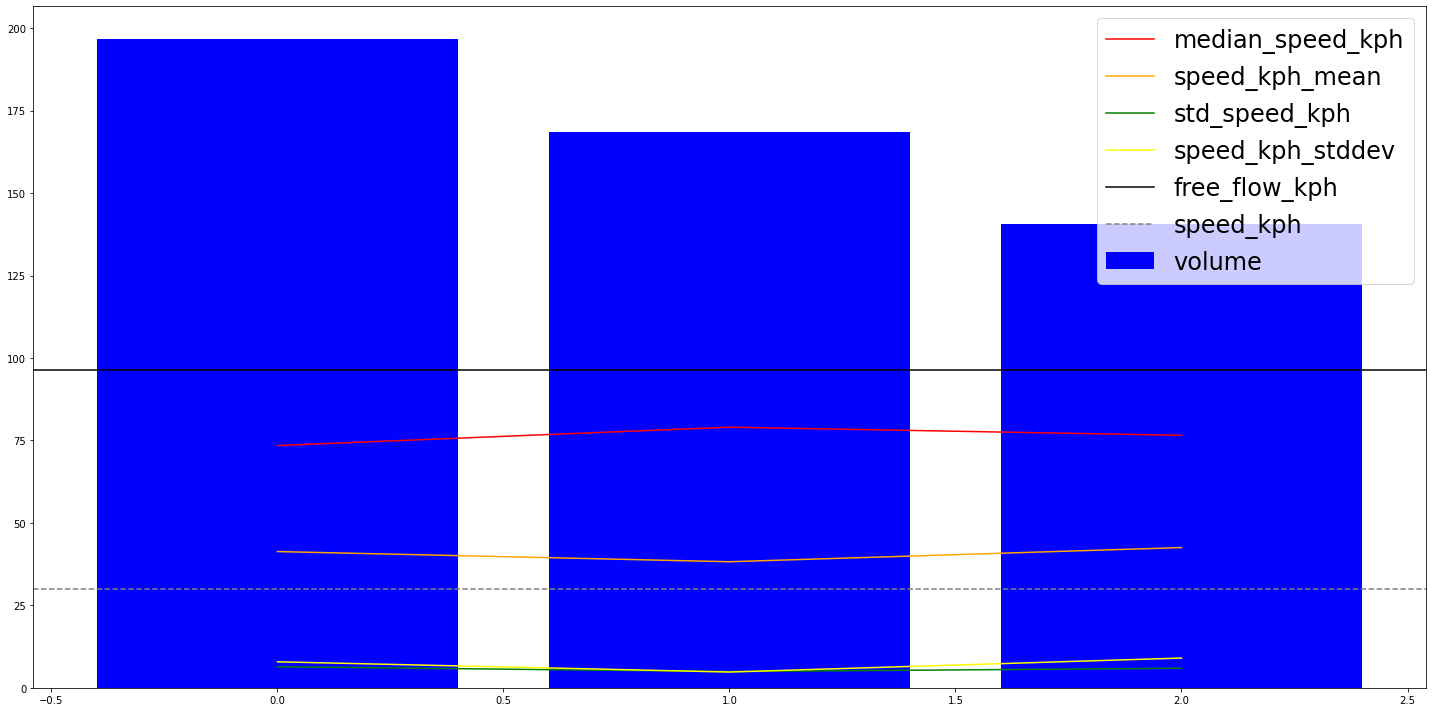

In [88]:
visualize_extreme_case(15)

## Inspect extreme cases (speed_diff < -10 and median_speed_kph < 15)

In [89]:
cols = [
    "year",
    "month",
    "day",
    "hour",
    "speed_diff",
    "std_speed_kph",
    "median_speed_kph",
    "speed_kph_mean",
    "free_flow_kph",
    "speed_kph",
    "length_meters",
    "x_u",
    "y_u",
    "x_v",
    "y_v",
]

extreme_edges_low = (
    ut_merged[(ut_merged["speed_diff"] < -10) & (ut_merged["median_speed_kph"] < 15)]
    .groupby(["u", "v", "gkey"])
    .agg(**{col: (col, "mean") for col in cols}, count=("year", "count"), name=("name", "first"), highway=("highway", "first"))
    .reset_index()[cols + ["name", "count", "u", "v", "gkey", "highway"]]
    .sort_values("speed_diff", ascending=True)
)
extreme_edges_low = extreme_edges_low[extreme_edges_low["count"] > 1]
extreme_edges_low

,year,month,day,hour,speed_diff,std_speed_kph,median_speed_kph,speed_kph_mean,free_flow_kph,speed_kph,...,x_u,y_u,x_v,y_v,name,count,u,v,gkey,highway
256,2019.0,2.0,4.400000,14.600000,-46.235063,9.620603,13.543137,59.77820,38.901961,50.0,...,13.369541,52.523488,13.368046,52.525360,Tunnel Tiergarten Spreebogen,5,2428559335,27401012,2428559335_27401012_48859719,trunk
97,2019.0,2.0,4.333333,16.000000,-43.260059,15.141984,14.352941,57.61300,43.294118,50.0,...,13.368046,52.525360,13.367686,52.526438,Tunnel Tiergarten Spreebogen,3,27401012,26754225,27401012_26754225_48859719,trunk
94,2019.0,2.0,3.750000,12.625000,-36.381230,9.564519,13.611520,49.99275,41.411765,50.0,...,13.369757,52.523381,13.367972,52.525122,Tunnel Tiergarten Spreebogen,8,27000364,26871994,27000364_26871994_4412690,trunk
64,2019.0,2.0,6.000000,12.500000,-25.672294,6.112745,14.014706,39.68700,33.725490,50.0,...,13.330763,52.500397,13.330905,52.500411,Lietzenburger Straße,2,26761220,26761221,26761220_26761221_318886184,secondary
39,2019.0,2.0,6.666667,8.666667,-25.169928,5.712418,14.013072,39.18300,36.941176,50.0,...,13.307202,52.499934,13.307149,52.500098,Lewishamstraße,3,26708501,312215682,26708501_312215682_4444438,secondary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2019.0,2.0,3.500000,14.500000,-11.637902,0.666667,9.745098,21.38300,26.509804,50.0,...,13.405838,52.513995,13.405667,52.514123,Breite Straße,2,29207836,21487285,29207836_21487285_37289106,tertiary
13,2019.0,2.0,7.000000,16.500000,-11.312765,0.000000,14.588235,25.90100,21.176471,30.0,...,13.383428,52.511468,13.383164,52.511391,Voßstraße,2,25661372,3380065527,25661372_3380065527_197160273,residential
254,2019.0,2.0,3.500000,14.500000,-11.080196,0.000000,9.509804,20.59000,52.549020,50.0,...,13.403509,52.512375,13.403781,52.512560,Gertraudenstraße,2,2302455925,1475313873,2302455925_1475313873_625843709,primary
264,2019.0,2.0,4.500000,12.500000,-10.617549,0.000000,10.627451,21.24500,45.647059,50.0,...,13.417642,52.521760,13.417245,52.521880,Karl-Marx-Allee,2,2921377244,2922881190,2921377244_2922881190_288585010,primary


year                                      2019.0
month                                        2.0
day                                          4.4
hour                                        14.6
speed_diff                            -46.235063
std_speed_kph                           9.620603
median_speed_kph                       13.543137
speed_kph_mean                           59.7782
free_flow_kph                          38.901961
speed_kph                                   50.0
length_meters                         261.975988
x_u                                    13.369541
y_u                                    52.523488
x_v                                    13.368046
y_v                                     52.52536
name                Tunnel Tiergarten Spreebogen
count                                          5
u                                     2428559335
v                                       27401012
gkey                2428559335_27401012_48859719
highway             

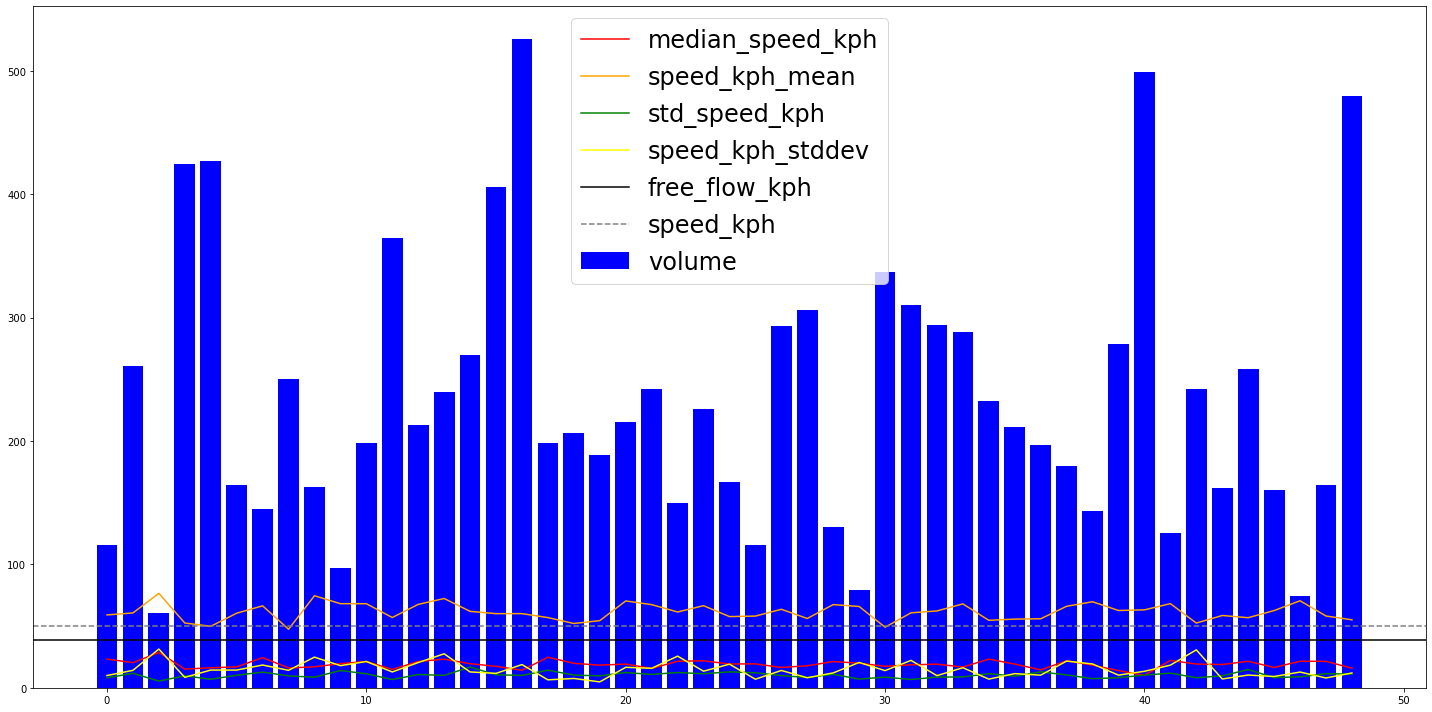

In [90]:
visualize_extreme_case(0, extreme_edges_low)

year                                      2019.0
month                                        2.0
day                                     4.333333
hour                                        16.0
speed_diff                            -43.260059
std_speed_kph                          15.141984
median_speed_kph                       14.352941
speed_kph_mean                            57.613
free_flow_kph                          43.294118
speed_kph                                   50.0
length_meters                         123.298348
x_u                                    13.368046
y_u                                     52.52536
x_v                                    13.367686
y_v                                    52.526438
name                Tunnel Tiergarten Spreebogen
count                                          3
u                                       27401012
v                                       26754225
gkey                  27401012_26754225_48859719
highway             

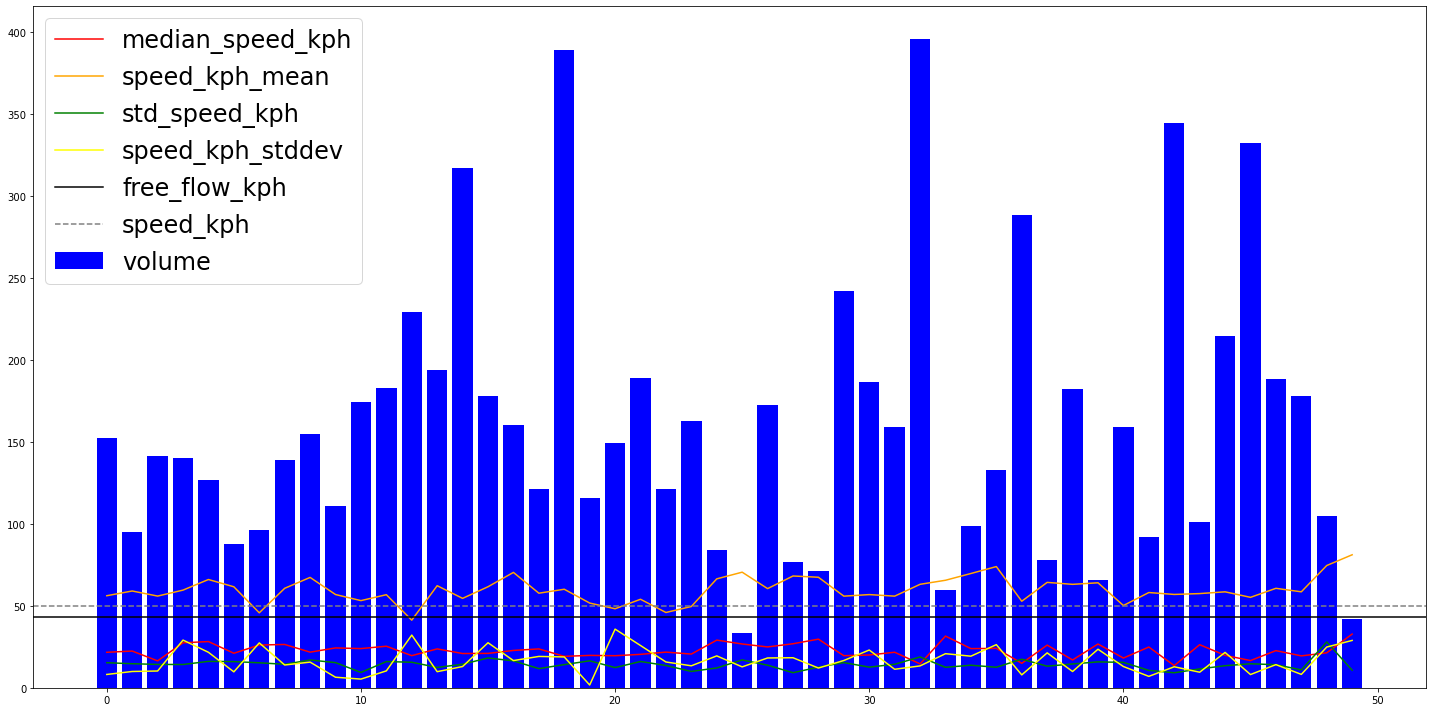

In [91]:
visualize_extreme_case(1, extreme_edges_low)

year                                      2019.0
month                                        2.0
day                                         3.75
hour                                      12.625
speed_diff                             -36.38123
std_speed_kph                           9.564519
median_speed_kph                        13.61152
speed_kph_mean                          49.99275
free_flow_kph                          41.411765
speed_kph                                   50.0
length_meters                         273.631859
x_u                                    13.369757
y_u                                    52.523381
x_v                                    13.367972
y_v                                    52.525122
name                Tunnel Tiergarten Spreebogen
count                                          8
u                                       27000364
v                                       26871994
gkey                   27000364_26871994_4412690
highway             

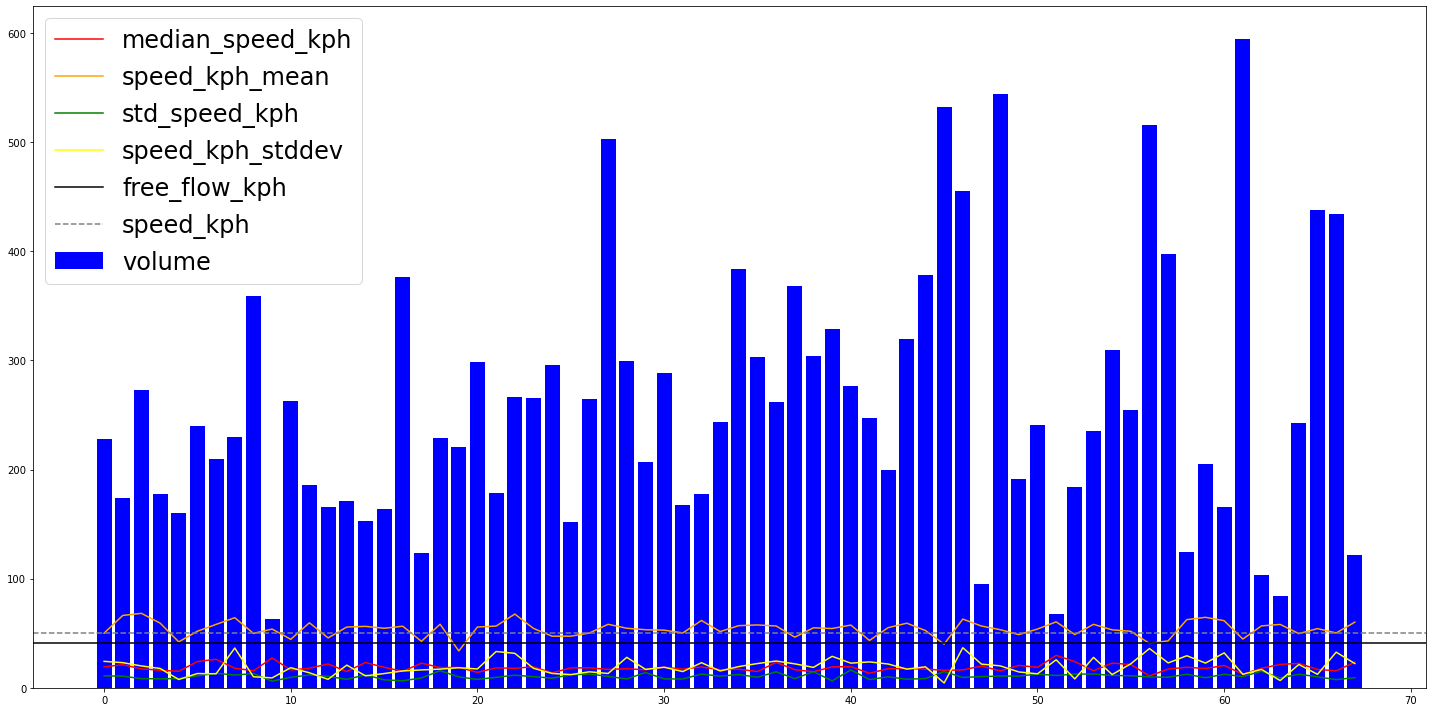

In [92]:
visualize_extreme_case(2, extreme_edges_low)

year                                   2019.0
month                                     2.0
day                                       2.5
hour                                     13.0
speed_diff                         -15.958742
std_speed_kph                             0.0
median_speed_kph                    13.228758
speed_kph_mean                        29.1875
free_flow_kph                       23.058824
speed_kph                                50.0
length_meters                       34.217311
x_u                                 13.430113
y_u                                 52.510193
x_v                                 13.430249
y_v                                 52.510477
name                   An der Schillingbrücke
count                                       2
u                                    29273064
v                                    29273065
gkey                29273064_29273065_4616599
highway                             secondary
Name: 126, dtype: object
intersect

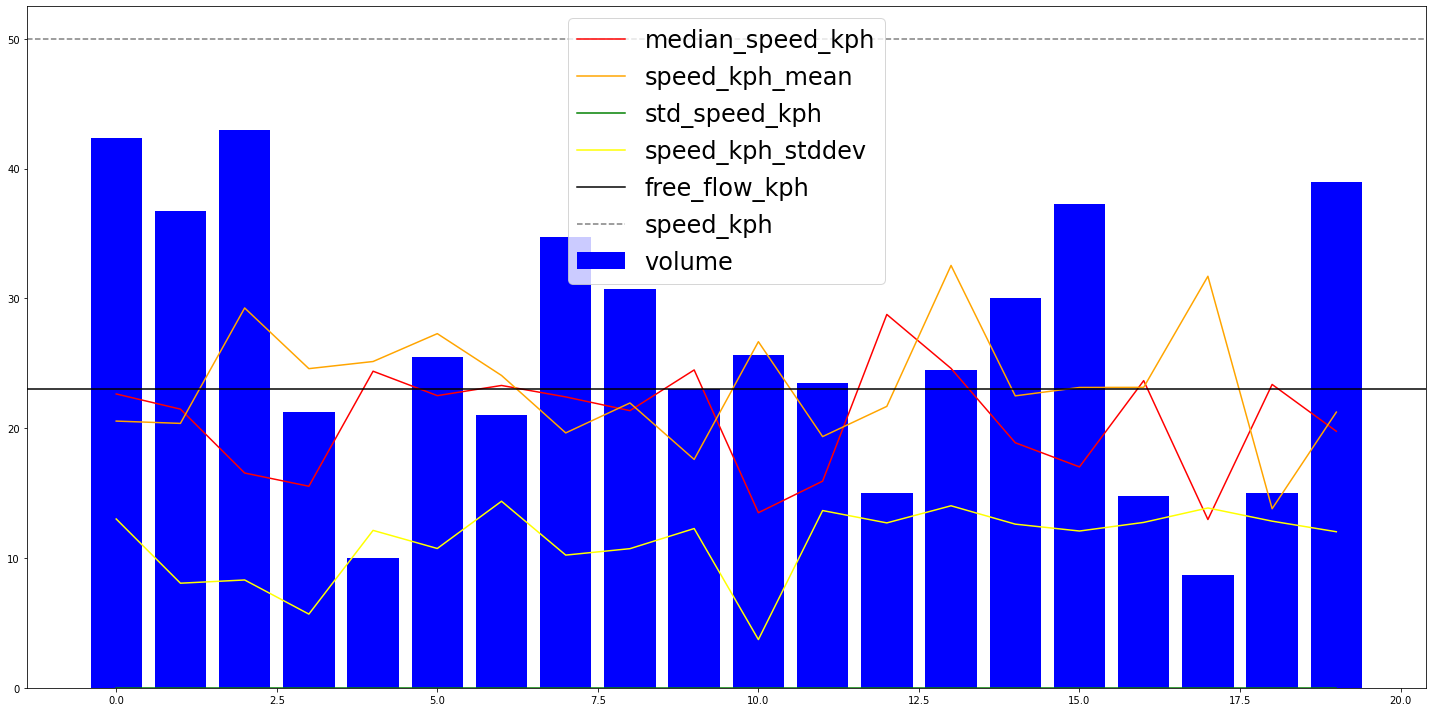

In [93]:
visualize_extreme_case(55, extreme_edges_low)

year                                     2019.0
month                                       2.0
day                                         5.0
hour                                       14.0
speed_diff                           -11.848078
std_speed_kph                          2.666667
median_speed_kph                      13.137255
speed_kph_mean                        24.985333
free_flow_kph                         24.627451
speed_kph                                  50.0
length_meters                         28.137058
x_u                                   13.380295
y_u                                   52.518906
x_v                                   13.380343
y_v                                   52.518651
name                              Wilhelmstraße
count                                         3
u                                      26861434
v                                    4351377009
gkey                26861434_4351377009_4588211
highway                                t

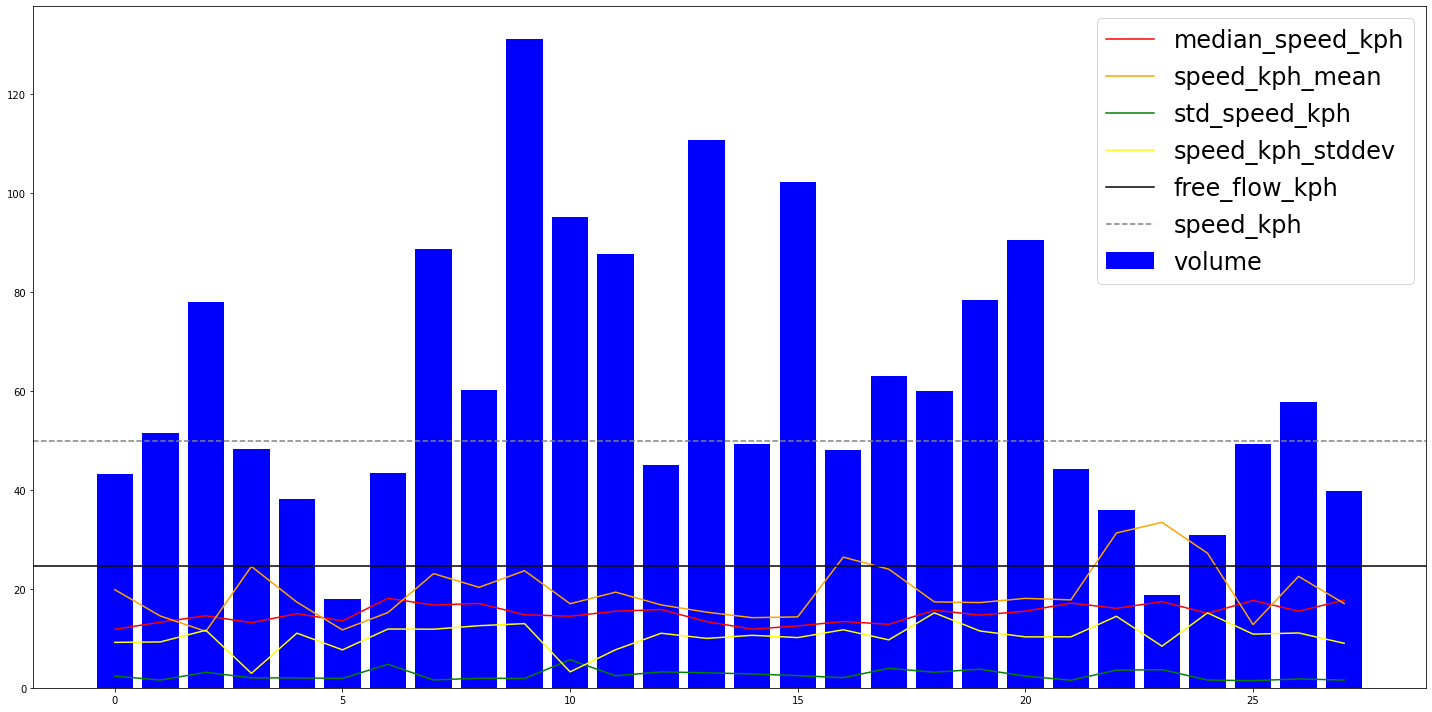

In [94]:
visualize_extreme_case(90, extreme_edges_low)

year                                   2019.0
month                                     2.0
day                                       2.5
hour                                     13.0
speed_diff                         -15.958742
std_speed_kph                             0.0
median_speed_kph                    13.228758
speed_kph_mean                        29.1875
free_flow_kph                       23.058824
speed_kph                                50.0
length_meters                       34.217311
x_u                                 13.430113
y_u                                 52.510193
x_v                                 13.430249
y_v                                 52.510477
name                   An der Schillingbrücke
count                                       2
u                                    29273064
v                                    29273065
gkey                29273064_29273065_4616599
highway                             secondary
Name: 126, dtype: object
intersect

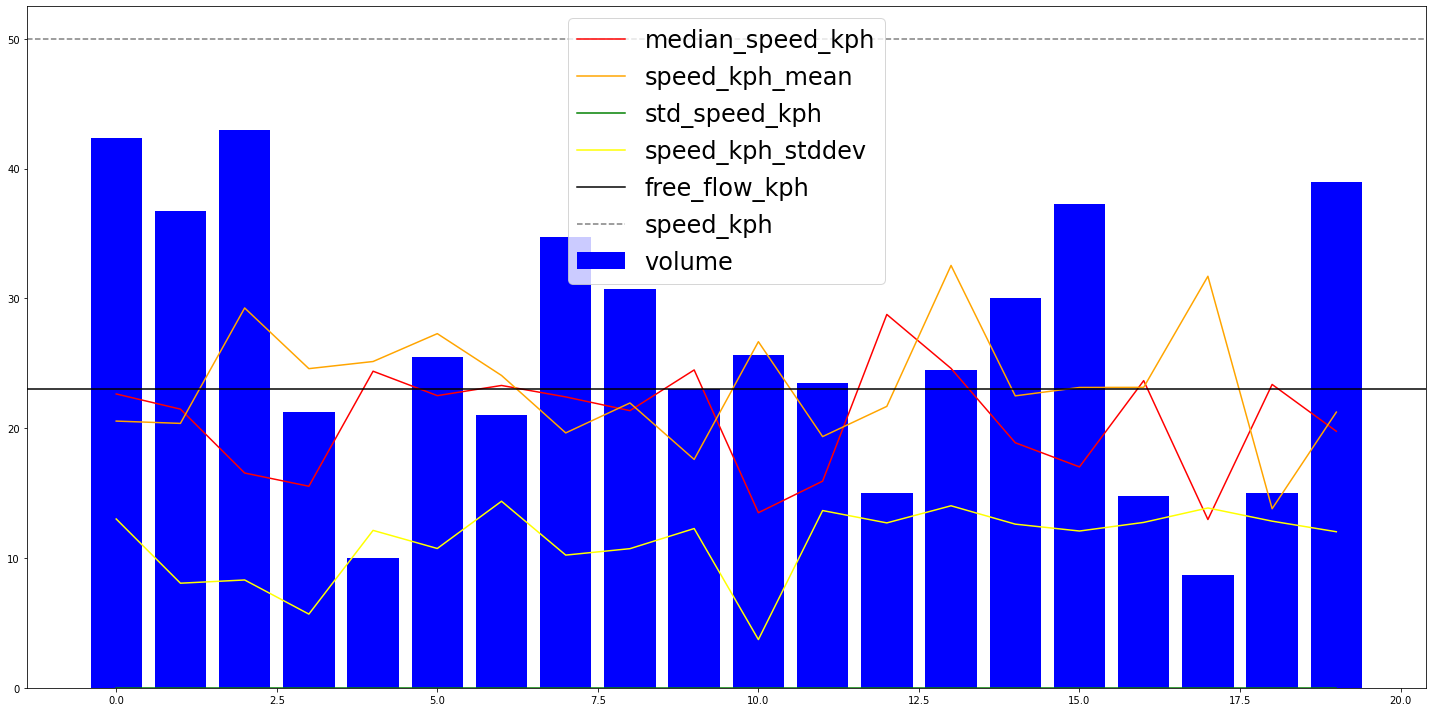

In [95]:
visualize_extreme_case(55, extreme_edges_low)

year                                       2019.0
month                                         2.0
day                                           3.5
hour                                         13.5
speed_diff                             -16.954422
std_speed_kph                                 0.0
median_speed_kph                        11.196078
speed_kph_mean                            28.1505
free_flow_kph                           21.176471
speed_kph                                    30.0
length_meters                           30.500711
x_u                                     13.383164
y_u                                     52.511391
x_v                                     13.383428
y_v                                     52.511468
name                                    Voßstraße
count                                           2
u                                      3380065527
v                                        25661372
gkey                3380065527_25661372_197160273


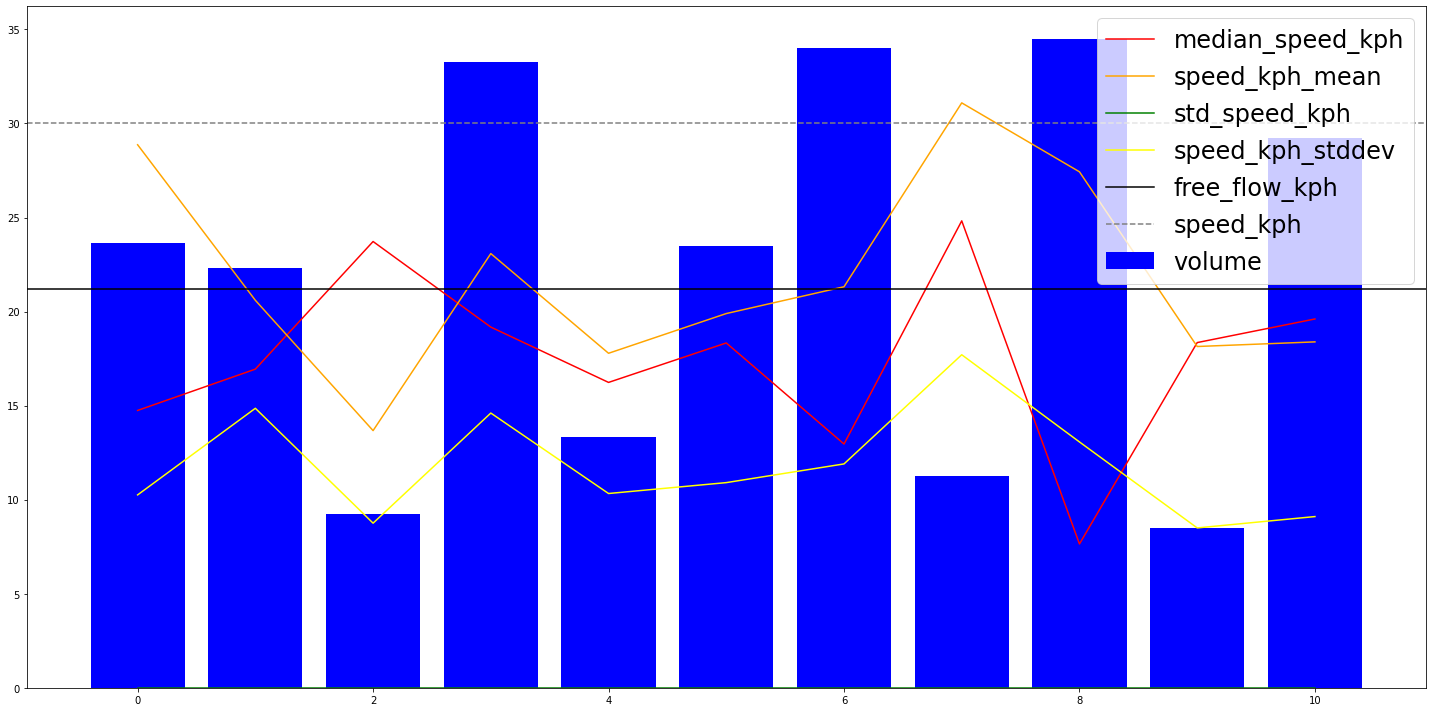

In [96]:
visualize_extreme_case(43, extreme_edges_low)

In [97]:
extreme_edges_low.groupby("highway").count()

,year,month,day,hour,speed_diff,std_speed_kph,median_speed_kph,speed_kph_mean,free_flow_kph,speed_kph,length_meters,x_u,y_u,x_v,y_v,name,count,u,v,gkey
highway,,,,,,,,,,,,,,,,,,,,
primary,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46
residential,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
secondary,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
tertiary,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
trunk,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
unclassified,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [98]:
extreme_edges_low.groupby("highway").median()

,year,month,day,hour,speed_diff,std_speed_kph,median_speed_kph,speed_kph_mean,free_flow_kph,speed_kph,length_meters,x_u,y_u,x_v,y_v,count,u,v
highway,,,,,,,,,,,,,,,,,,
primary,2019.0,2.0,3.500000,13.000000,-15.841791,0.000000,13.544249,29.238333,39.490196,50.0,23.035785,13.407308,52.519869,13.407136,52.519585,2.0,1.347395e+09,1.269772e+09
residential,2019.0,2.0,4.750000,14.750000,-19.196637,0.000000,10.656863,28.713500,21.176471,30.0,30.500711,13.383296,52.506913,13.383296,52.506965,2.0,1.215216e+09,1.899831e+08
secondary,2019.0,2.0,4.550000,13.000000,-16.774879,0.000000,13.278322,30.760500,31.058824,50.0,26.177045,13.337238,52.505765,13.336971,52.505725,3.0,2.927216e+07,2.927306e+07
tertiary,2019.0,2.0,2.750000,14.250000,-14.249059,5.001404,11.093137,25.408500,27.294118,40.0,25.800095,13.391991,52.521351,13.391967,52.521557,2.0,2.920040e+07,3.086103e+08
trunk,2019.0,2.0,4.041667,13.893750,-39.820645,9.592561,13.577328,53.802875,40.156863,50.0,192.637168,13.368793,52.524305,13.367976,52.525537,6.5,2.720069e+07,2.713650e+07
unclassified,2019.0,2.0,2.666667,12.333333,-17.065497,0.000000,13.424837,30.490333,35.450980,50.0,20.667728,13.296549,52.548280,13.296655,52.548123,3.0,2.687124e+07,2.687112e+07


In [99]:
extreme_edges_low.groupby("highway").max()

,year,month,day,hour,speed_diff,std_speed_kph,median_speed_kph,speed_kph_mean,free_flow_kph,speed_kph,length_meters,x_u,y_u,x_v,y_v,name,count,u,v,gkey
highway,,,,,,,,,,,,,,,,,,,,
primary,2019.0,2.0,6.666667,16.666667,-10.617549,10.642157,14.686275,38.328000,64.470588,50.0,130.014887,13.454214,52.543353,13.454198,52.543393,Wilhelmstraße,18,5931763565,4819973789,961878738_1264074482_82649618
residential,2019.0,2.0,7.000000,16.500000,-11.312765,0.470588,14.588235,31.556500,34.352941,50.0,47.877218,13.446405,52.511468,13.446765,52.511468,Voßstraße,2,3380065527,3380065527,3380065527_25661372_197160273
secondary,2019.0,2.0,7.000000,17.000000,-10.277157,16.613537,14.320261,39.687000,60.705882,50.0,67.991627,13.516043,52.548004,13.516100,52.548001,Warschauer Straße,11,5845560525,5845560525,77752644_26871119_4537637
tertiary,2019.0,2.0,5.000000,17.000000,-11.637902,7.633049,13.137255,30.426500,35.294118,50.0,87.400218,13.405838,52.529199,13.405667,52.528610,Wilhelmstraße,3,2812123973,4351377009,588181303_588181295_46140378
trunk,2019.0,2.0,4.400000,16.000000,-22.895129,15.141984,14.352941,59.778200,43.294118,50.0,273.631859,13.369757,52.525360,13.368046,52.526438,Tunnel Tiergarten Spreebogen,16,2428559335,2089375240,27401012_26754225_48859719
unclassified,2019.0,2.0,2.666667,12.333333,-17.065497,0.000000,13.424837,30.490333,35.450980,50.0,20.667728,13.296549,52.548280,13.296655,52.548123,,3,26871235,26871121,26871235_26871121_4537642


In [100]:
extreme_edges_low[extreme_edges_low["length_meters"] > 150]

,year,month,day,hour,speed_diff,std_speed_kph,median_speed_kph,speed_kph_mean,free_flow_kph,speed_kph,...,x_u,y_u,x_v,y_v,name,count,u,v,gkey,highway
256,2019.0,2.0,4.40,14.600,-46.235063,9.620603,13.543137,59.77820,38.901961,50.0,...,13.369541,52.523488,13.368046,52.525360,Tunnel Tiergarten Spreebogen,5,2428559335,27401012,2428559335_27401012_48859719,trunk
94,2019.0,2.0,3.75,12.625,-36.381230,9.564519,13.611520,49.99275,41.411765,50.0,...,13.369757,52.523381,13.367972,52.525122,Tunnel Tiergarten Spreebogen,8,27000364,26871994,27000364_26871994_4412690,trunk
